In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import data
import numpy as np
import plotly.express as px
import itertools

%matplotlib inline

main_dir = Path('model/classification')
fields = data.load_fields(main_dir)
comms = fields['community'].vocab.itos

token_ids = list(map(str, range(64)))
token_ids_ = token_ids + ['final']

model/classification/text.field
Using existing fields.


What are we doing? We have two community classifiers; that is, functions that given a message, give us a prediction about what community it came from. The first classifier is a naive bayes unigram model with some smoothing. The second model is an LSTM that was trained to predict community based on the final hidden state of the model. Either model can produce predictions at any token, though.

Our research interest centers on how communities can be distinguished based on the language their members use. 
* Does the inference come down to token frequency alone or are multi-token expressions predictive beyond their component parts?
    * Is this situation different in different communities?
* How long (at what point in a message) does it take to identify a community? Is this different for different communities?
    * Is this situation different in different communities

We will use a few tools to ask investigate these questions:
* The token-by-token predictions and entropy & cross entropy of the prediction distributions, given by both models
* The difference between the entropy/cross entropy of the prediction distributions at the n and n+1st tokens (i.e., the information gain of the additional token).
* The difference between the entropy of the unigram and LSTM predictions (i.e., the information gain of the considering the left context vs. naively assuming independence of the tokens)

In [2]:
index = ['community', 'example_id']
metrics = ['pred', 'entropy', 'cross_entropy']
m_types = dict(zip(metrics, ['int64', 'float64', 'float64']))
models = ['lstm', 'unigram']

dfs = {}
for metric in metrics:
    df = pd.concat([pd.read_csv(main_dir/model/f'{metric}.csv').set_index(index) for model in models], 
              axis=0, keys=models, names=['model'])
    df['final'] = df[token_ids].values[np.arange(len(df)),df['length'].values-1]
    df[token_ids_] = df[token_ids_].astype("Int64" if metric == 'pred' else "Float64")
    df['true_comm'] = df.index.to_series().apply(lambda x: comms[x[1]])
    dfs[metric] = df
    
for i in token_ids_:
    dfs['pred'][i] = dfs['pred'][i].apply(lambda x: comms[x] if pd.notna(x) else None)

dfs['correct_pred'] = dfs['pred'].copy()
for i in token_ids_:
    dfs['correct_pred'][i] = dfs['pred'][i] == dfs['pred']['true_comm']
metrics.append('correct_pred')

In [3]:
print("           LSTM     Unigram")
print("Accuracy:   {lstm:>7.4f} {unigram:>7.4f}".format(**dfs['correct_pred'].groupby('model')['final'].mean()))
print("Cross Entr: {lstm:>7.4f} {unigram:>7.4f}".format(**dfs['cross_entropy'].replace(np.inf, np.nan).dropna().groupby('model')['final'].mean()))
print("Entropy:    {lstm:>7.4f} {unigram:>7.4f}".format(**dfs['entropy'].groupby('model')['final'].mean()))

           LSTM     Unigram
Accuracy:    0.0880  0.2581
Cross Entr: 20.4746  6.5000
Entropy:     0.7190  2.3580


In [4]:
comm_acc = dfs['correct_pred'].loc['lstm'].groupby('true_comm')['final'].mean()
ok_comms = comm_acc[comm_acc > .01].index

for metric in metrics:
    dfs[metric] = dfs[metric][dfs[metric]['true_comm'].isin(ok_comms)]

In [14]:
len(ok_comms)

115

In [5]:
print("           LSTM     Unigram")
print("Accuracy:   {lstm:>7.4f} {unigram:>7.4f}".format(**dfs['correct_pred'].groupby('model')['final'].mean()))
print("Cross Entr: {lstm:>7.4f} {unigram:>7.4f}".format(**dfs['cross_entropy'].replace(np.inf, np.nan).dropna().groupby('model')['final'].mean()))
print("Entropy:    {lstm:>7.4f} {unigram:>7.4f}".format(**dfs['entropy'].groupby('model')['final'].mean()))

           LSTM     Unigram
Accuracy:    0.3901  0.3333
Cross Entr:  4.4961  6.4852
Entropy:     0.5459  2.3433


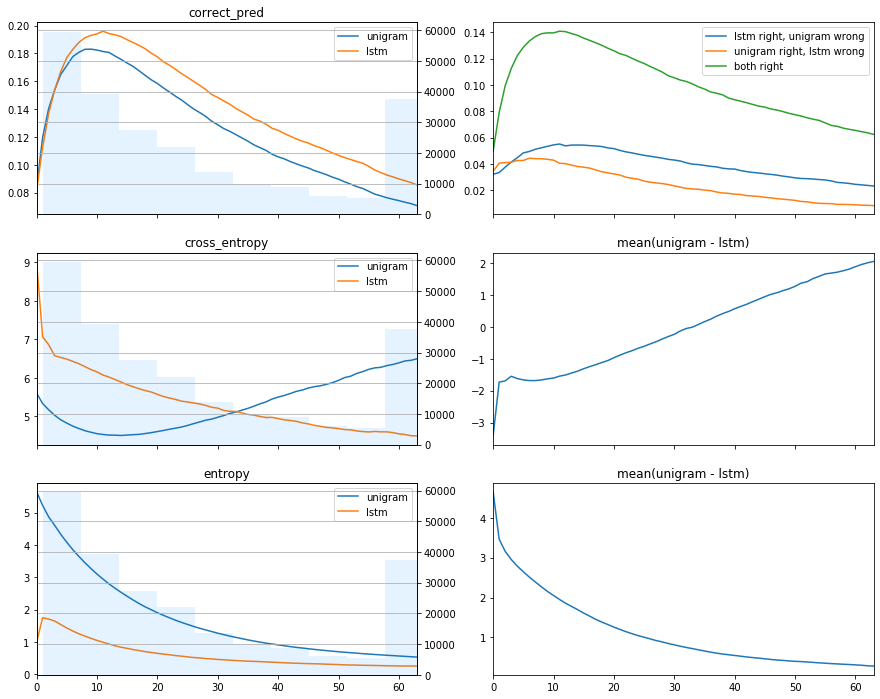

In [15]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=False, figsize=(15,12))

for i, m in enumerate(['correct_pred', 'cross_entropy', 'entropy']):
    df = dfs[m]
    ax_hist = axs[i][0].twinx()
    dfs['pred'].length.hist(ax=ax_hist, color=(0,0.5,1,0.1))
    unig = df.loc['unigram'][token_ids].replace(np.inf, np.nan)
    unig_mean = unig.mean(skipna=True)
    unig_mean.plot(ax=axs[i][0])
    lstm = df.loc['lstm'][token_ids]
    lstm_mean = lstm.mean()
    lstm_mean.plot(ax=axs[i][0])
    if m == 'correct_pred':
        (df.loc['lstm'][token_ids] & ~df.loc['unigram'][token_ids]).mean().plot(ax=axs[i][1])
        (~df.loc['lstm'][token_ids] & df.loc['unigram'][token_ids]).mean().plot(ax=axs[i][1])
        (df.loc['lstm'][token_ids] & df.loc['unigram'][token_ids]).mean().plot(ax=axs[i][1])
#         (~df.loc['lstm'][token_ids] & ~df.loc['unigram'][token_ids]).mean().plot(ax=axs[i][1])
        axs[i][1].legend(['lstm right, unigram wrong', 'unigram right, lstm wrong', 'both right'])#, 'both wrong'])
    else:
        (df.loc['unigram'][token_ids] - df.loc['lstm'][token_ids]).replace(np.inf, np.nan).mean(skipna=True).plot(ax=axs[i][1], title='mean(unigram - lstm)')
    axs[i][0].legend(['unigram', 'lstm'])
    axs[i][0].set_title(m)
plt.show()

In [7]:
import plotly.express as px
import plotly.graph_objects as go

def plot_confusion(C, labels):
    fig = go.Figure(data=go.Heatmap(z=C, x=labels, y=labels))
    fig.update_layout(height=2*510, width=2*510, font=dict(size=8), title='')
    return fig.show()

itoc = list(ok_comms)
ctoi = {c: i for i, c in enumerate(itoc)}

In [8]:
C = np.zeros((len(itoc),len(itoc)))
for i, (real, pred) in dfs['pred'].loc['lstm'][['true_comm', 'final']].iterrows():
    if not pred in ok_comms:
        continue
    C[ctoi[real]][ctoi[pred]] += 1   

plot_confusion(C, ok_comms)

In [9]:
C = np.zeros((len(itoc),len(itoc)))
for i, (real, pred) in dfs['pred'].loc['unigram'][['true_comm', 'final']].iterrows():
    if not pred in ok_comms:
        continue
    C[ctoi[real]][ctoi[pred]] += 1   

plot_confusion(C, ok_comms) 

In [10]:
import data

data_dir = 'data/reddit_splits'
fields = data.load_fields(main_dir)
comm_to_idx = fields['community'].vocab.stoi
vocab = fields['text'].vocab.stoi

test_messages = data.load_data(data_dir, fields, 'test', 64, None)
test_messages = pd.Series({(comm_to_idx[ex.community], ex.example_id): 
            [t if t in vocab else t+"<unk>" for t in ex.text] for ex in test_messages})

model/classification/text.field
Using existing fields.
data/reddit_splits/2007scape.test.txt
data/reddit_splits/3DS.test.txt
data/reddit_splits/3Dprinting.test.txt
data/reddit_splits/4chan.test.txt
data/reddit_splits/ACTrade.test.txt
data/reddit_splits/ADHD.test.txt
data/reddit_splits/AMA.test.txt
data/reddit_splits/Advice.test.txt
data/reddit_splits/AdviceAnimals.test.txt
data/reddit_splits/AirForce.test.txt
data/reddit_splits/Anarchism.test.txt
data/reddit_splits/Anarcho_Capitalism.test.txt
data/reddit_splits/Android.test.txt
data/reddit_splits/Animesuggest.test.txt
data/reddit_splits/ApocalypseRising.test.txt
data/reddit_splits/Aquariums.test.txt
data/reddit_splits/Art.test.txt
data/reddit_splits/AsianBeauty.test.txt
data/reddit_splits/AskHistorians.test.txt
data/reddit_splits/AskMen.test.txt
data/reddit_splits/AskReddit.test.txt
data/reddit_splits/AskScienceFiction.test.txt
data/reddit_splits/AskWomen.test.txt
data/reddit_splits/Atlanta.test.txt
data/reddit_splits/Austin.test.txt
d

data/reddit_splits/bodyweightfitness.test.txt
data/reddit_splits/books.test.txt
data/reddit_splits/boston.test.txt
data/reddit_splits/brasil.test.txt
data/reddit_splits/bravefrontier.test.txt
data/reddit_splits/breakingmom.test.txt
data/reddit_splits/britishproblems.test.txt
data/reddit_splits/buildapc.test.txt
data/reddit_splits/buildapcforme.test.txt
data/reddit_splits/buildapcsales.test.txt
data/reddit_splits/canada.test.txt
data/reddit_splits/cars.test.txt
data/reddit_splits/casualiama.test.txt
data/reddit_splits/cats.test.txt
data/reddit_splits/changemyview.test.txt
data/reddit_splits/chelseafc.test.txt
data/reddit_splits/chicago.test.txt
data/reddit_splits/childfree.test.txt
data/reddit_splits/churning.test.txt
data/reddit_splits/cigars.test.txt
data/reddit_splits/circlejerk.test.txt
data/reddit_splits/civ.test.txt
data/reddit_splits/comicbooks.test.txt
data/reddit_splits/confession.test.txt
data/reddit_splits/conspiracy.test.txt
data/reddit_splits/cordcutters.test.txt
data/reddi

data/reddit_splits/survivor.test.txt
data/reddit_splits/sweden.test.txt
data/reddit_splits/swtor.test.txt
data/reddit_splits/sydney.test.txt
data/reddit_splits/syriancivilwar.test.txt
data/reddit_splits/sysadmin.test.txt
data/reddit_splits/talesfromtechsupport.test.txt
data/reddit_splits/technology.test.txt
data/reddit_splits/techsupport.test.txt
data/reddit_splits/teenagers.test.txt
data/reddit_splits/television.test.txt
data/reddit_splits/tf2.test.txt
data/reddit_splits/thatHappened.test.txt
data/reddit_splits/thenetherlands.test.txt
data/reddit_splits/tifu.test.txt
data/reddit_splits/tipofmytongue.test.txt
data/reddit_splits/todayilearned.test.txt
data/reddit_splits/toronto.test.txt
data/reddit_splits/trashy.test.txt
data/reddit_splits/travel.test.txt
data/reddit_splits/trees.test.txt
data/reddit_splits/truegaming.test.txt
data/reddit_splits/ukpolitics.test.txt
data/reddit_splits/ukraina.test.txt
data/reddit_splits/ultrahardcore.test.txt
data/reddit_splits/unitedkingdom.test.txt
dat

In [11]:
def anno_pred(ax, y, preds, true_comm, suffix=''):
    for x, (y, a) in enumerate(zip(y, preds)):
        if (x in (0,63) or a != prev) and a:
            prev = a
            if x <= 32:
                i = 0
            else: 
                i = 1
                x = x - 32
            ax[i].annotate(a+suffix, (x, y), rotation=30, ha="right", color = 'green' if a == true_comm else 'red')

def get_item(metric, model, idx):
    return dfs[metric].loc[model].loc[idx][token_ids]

def plot_message(idx):
    message = test_messages.loc[idx]
    lstm = get_item('cross_entropy', 'lstm', idx)
    unig = get_item('cross_entropy', 'unigram', idx)
    lstm_preds = get_item('pred', 'lstm', idx)
    unig_preds = get_item('pred', 'unigram', idx)
    true_comm = dfs['pred'].loc['lstm'].loc[idx]['true_comm']
    fig, ax = plt.subplots(2,1, sharex=False, sharey=True, figsize=(18,9))
    ax[1].spines['top'].set_visible(False)
    for i, (l,h) in [(0, (0,32)), (1, (32,64))]:
        ax[i].plot(lstm[l:h])
        ax[i].plot(unig[l:h])
        ax[i].set_xticks(range(32))
        ax[i].set_xticklabels(message[l:h])
        plt.setp(ax[i].get_xticklabels(), rotation=30, ha="right")
        anno_pred(ax, lstm, lstm_preds, true_comm, suffix='[L]')
        anno_pred(ax, unig, unig_preds, true_comm, suffix='[U]')
    fig.suptitle(f"{true_comm} - {idx}", fontsize=18)
    plt.show()
    print(' '.join(message)+'\n\n')

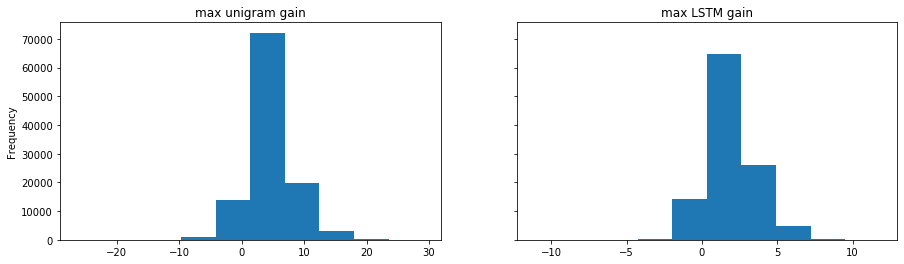

In [12]:
df = dfs['cross_entropy'].copy()
gain_ids = token_ids[1:]
for prev_idx, idx in zip(token_ids[:-1], gain_ids):
    df[idx] = dfs['cross_entropy'][prev_idx] - df[idx]
df = df.drop('0', axis=1)
dfs['info_gain'] = df

fig, axs = plt.subplots(1,2, sharex=False, sharey=True, figsize=(15,4))
df[gain_ids].replace(np.inf, np.nan).max(axis=1, skipna=True).loc['lstm'].plot(kind='hist', ax = axs[0], title='max unigram gain')
df[gain_ids].replace(np.inf, np.nan).max(axis=1, skipna=True).loc['unigram'].plot(kind='hist', ax = axs[1], title='max LSTM gain')
plt.show()

lstm_wins = (df[gain_ids].loc['lstm'] - df[gain_ids].loc['unigram'])[dfs['correct_pred']['final']['lstm'] & ~dfs['correct_pred']['final']['unigram']]

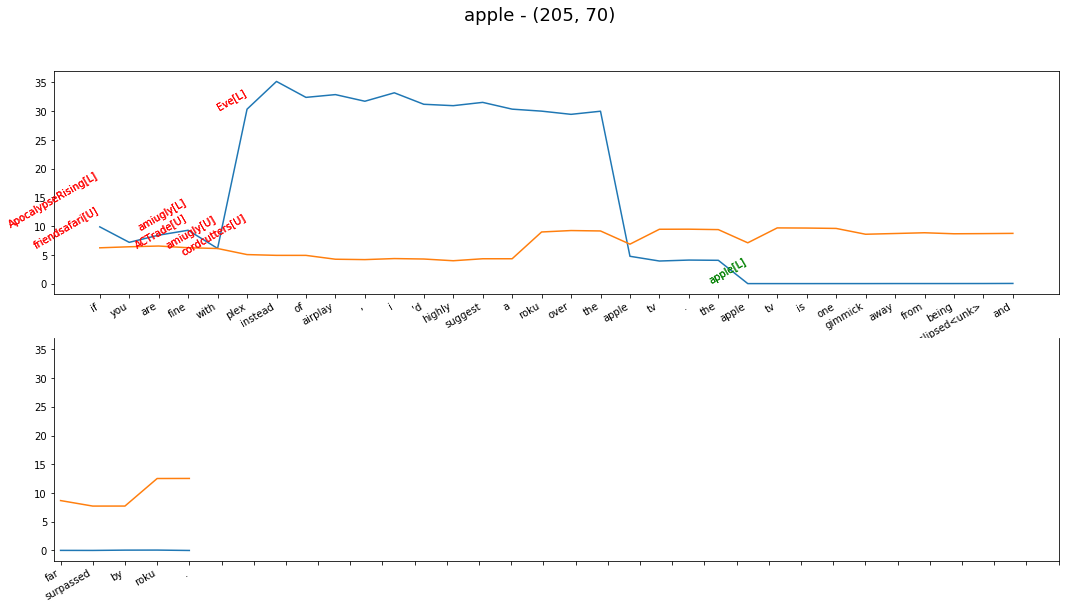

if you are fine with plex instead of airplay , i 'd highly suggest a roku over the apple tv . the apple tv is one gimmick away from being eclipsed<unk> and far surpassed by roku .




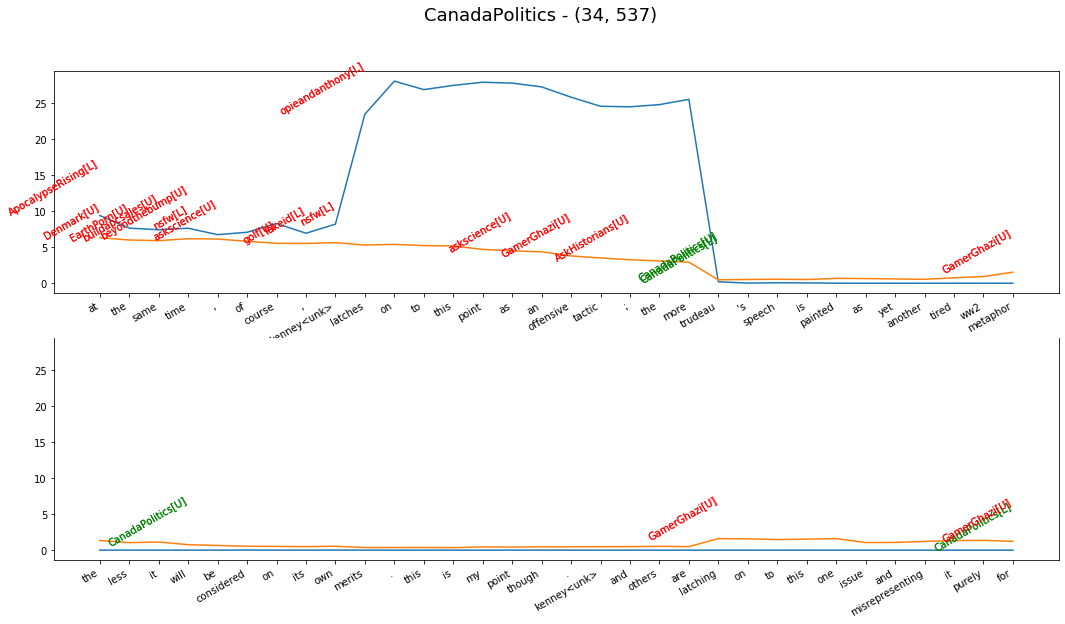

at the same time , of course , kenney<unk> latches on to this point as an offensive tactic ; the more trudeau 's speech is painted as yet another tired ww2 metaphor the less it will be considered on its own merits . this is my point though . kenney<unk> and others are latching on to this one issue and misrepresenting it purely for




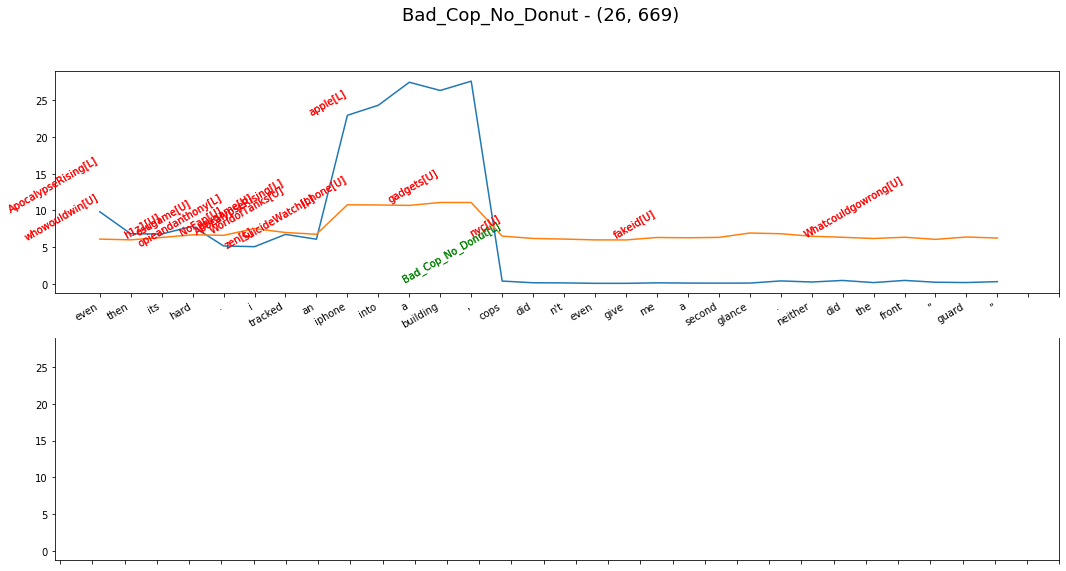

even then its hard . i tracked an iphone into a building , cops did n't even give me a second glance . neither did the front " guard "




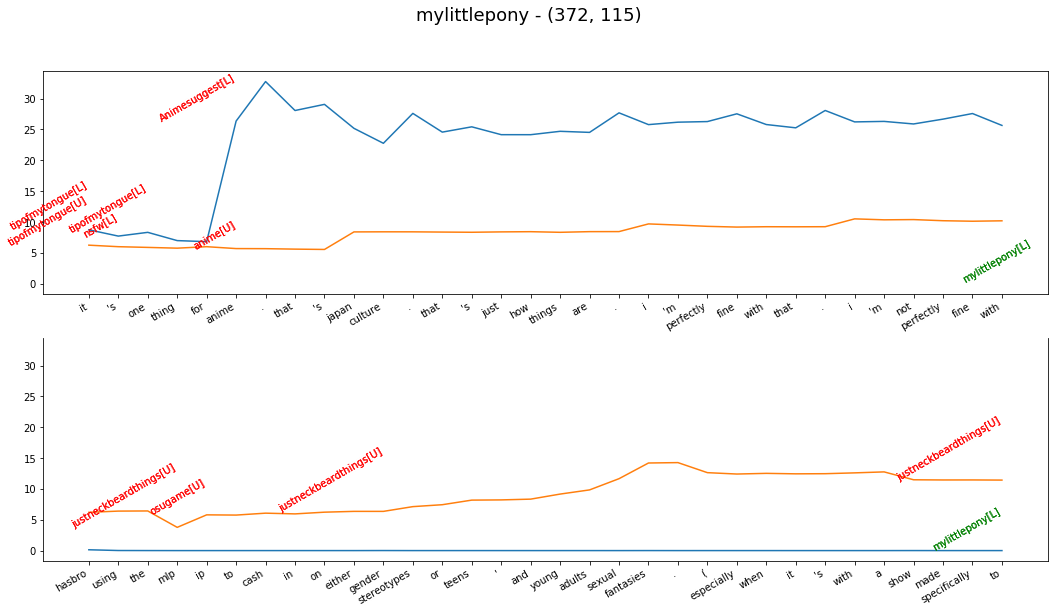

it 's one thing for anime . that 's japan culture . that 's just how things are . i 'm perfectly fine with that . i 'm not perfectly fine with hasbro using the mlp ip to cash in on either gender stereotypes or teens ' and young adults sexual fantasies . ( especially when it 's with a show made specifically to




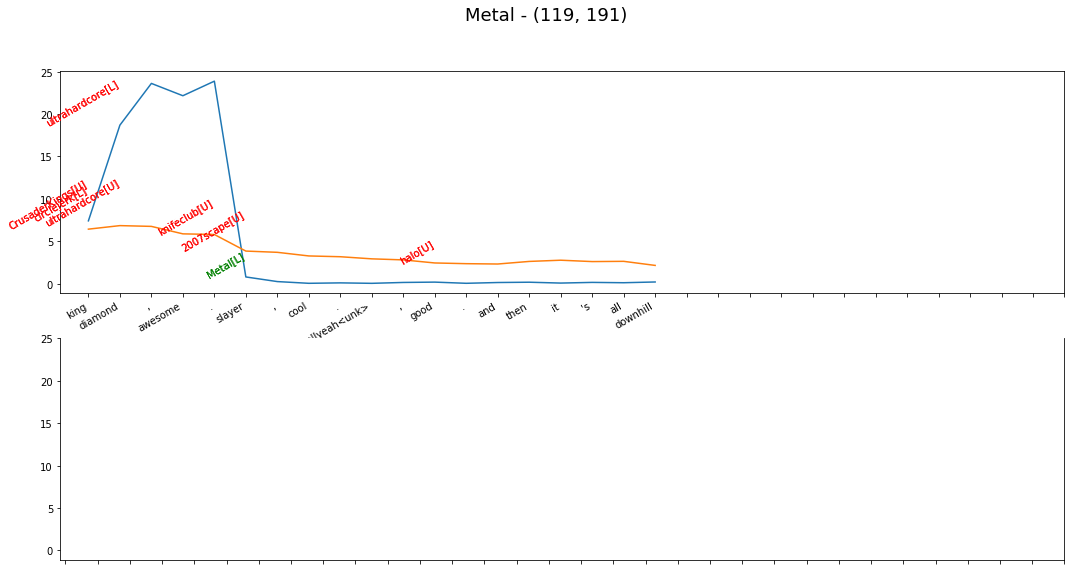

king diamond , awesome . slayer , cool . hellyeah<unk> , good . and then it 's all downhill




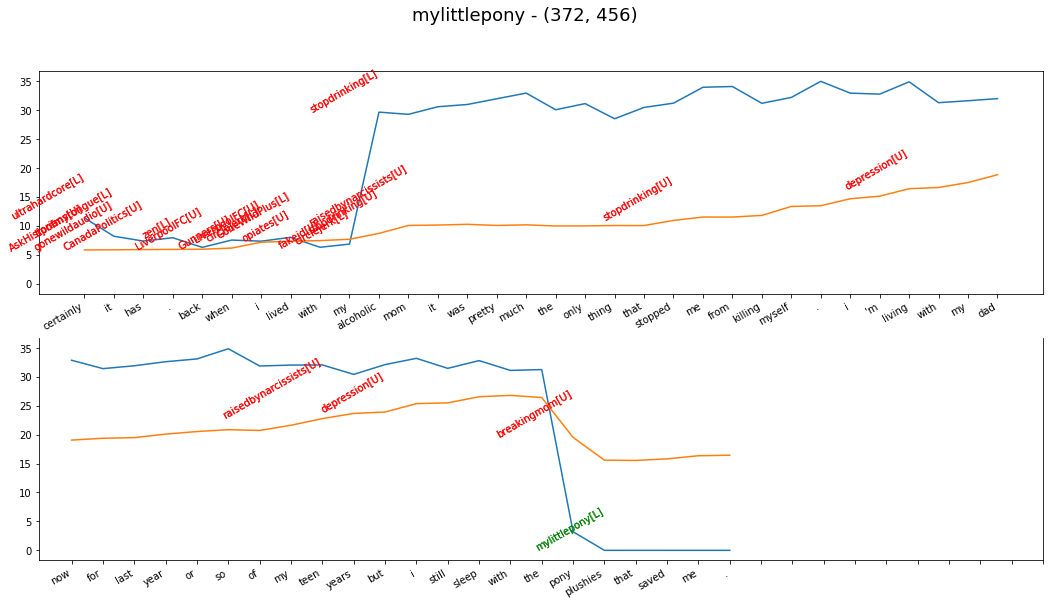

certainly it has . back when i lived with my alcoholic mom it was pretty much the only thing that stopped me from killing myself . i 'm living with my dad now for last year or so of my teen years but i still sleep with the pony plushies that saved me .




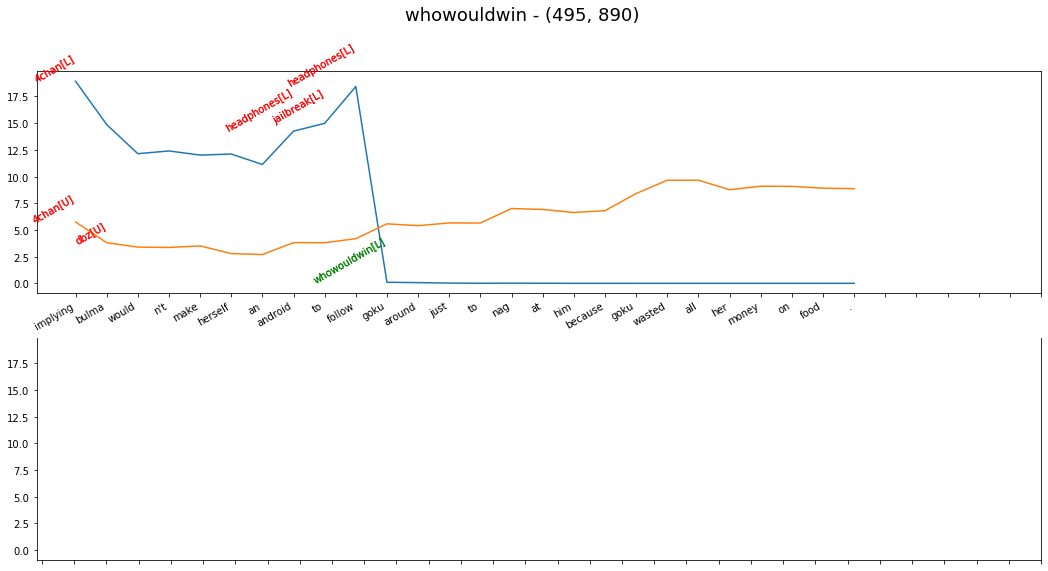

implying bulma would n't make herself an android to follow goku around just to nag at him because goku wasted all her money on food .




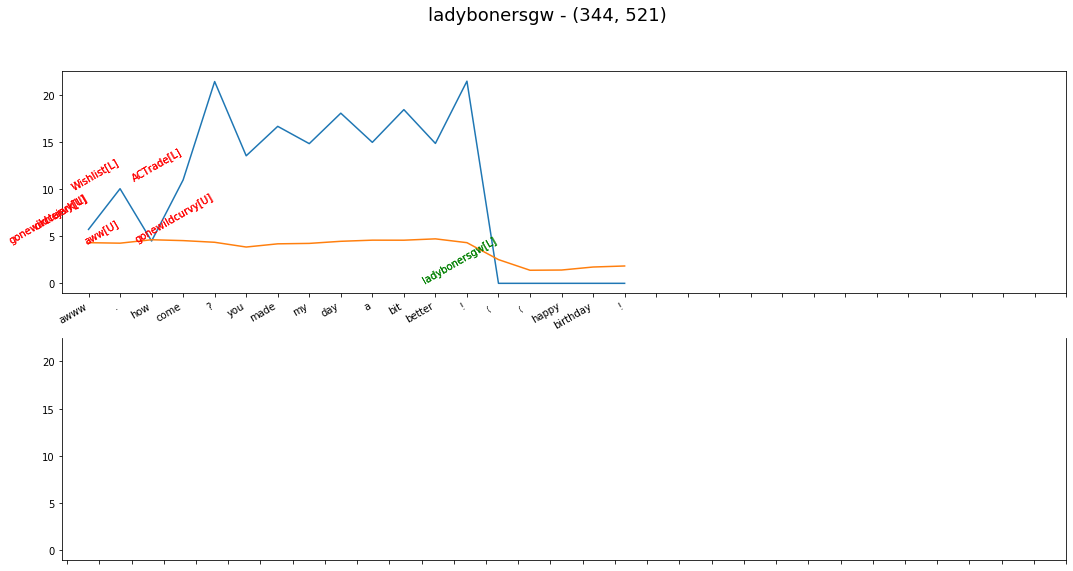

awww . how come ? you made my day a bit better ! 😍 😍 happy birthday !




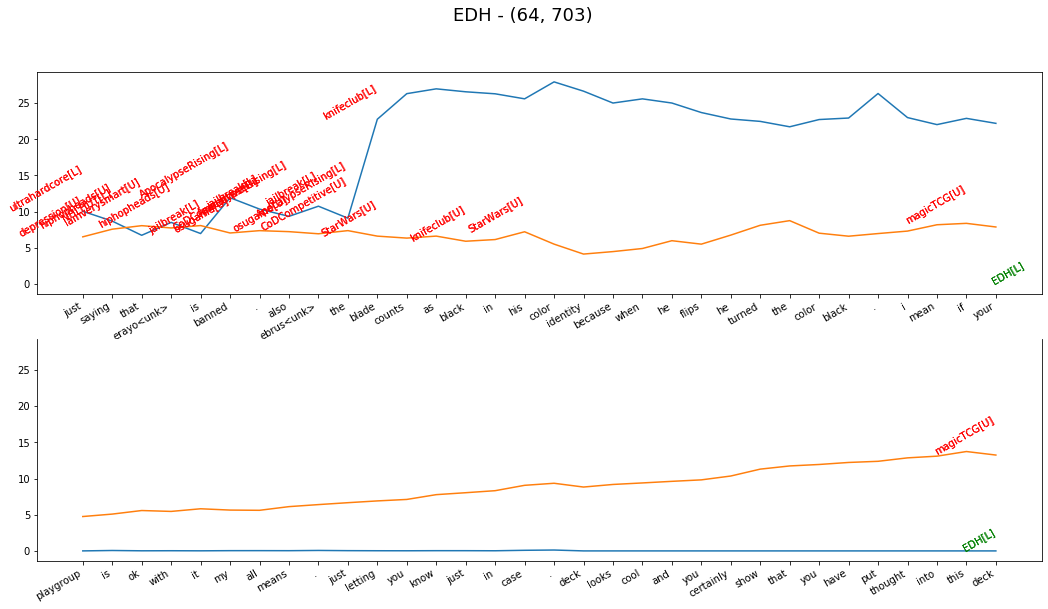

just saying that erayo<unk> is banned . also ebrus<unk> the blade counts as black in his color identity because when he flips he turned the color black . i mean if your playgroup is ok with it my all means . just letting you know just in case . deck looks cool and you certainly show that you have put thought into this deck




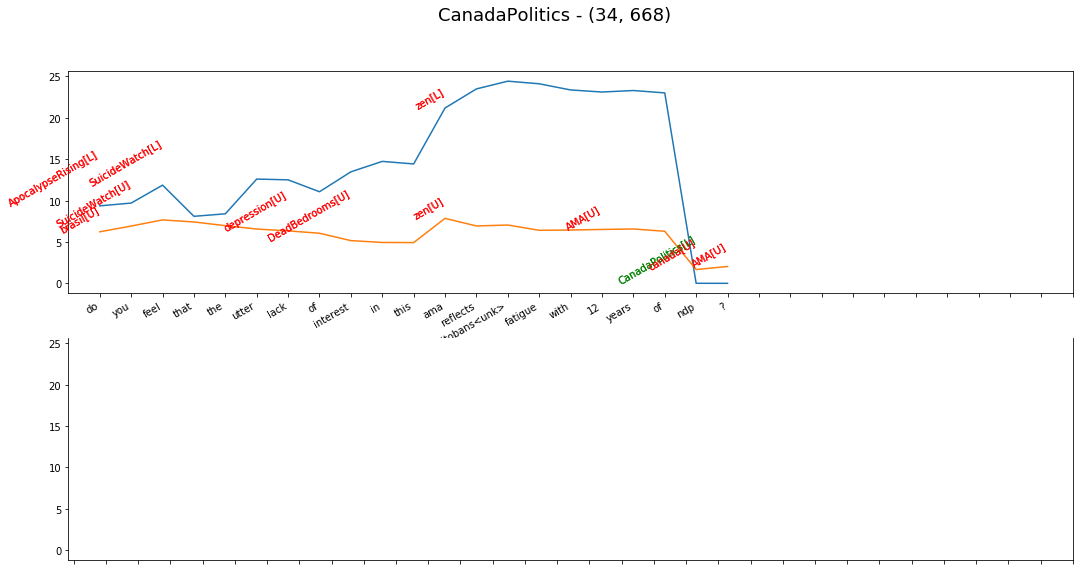

do you feel that the utter lack of interest in this ama reflects manitobans<unk> fatigue with 12 years of ndp ?




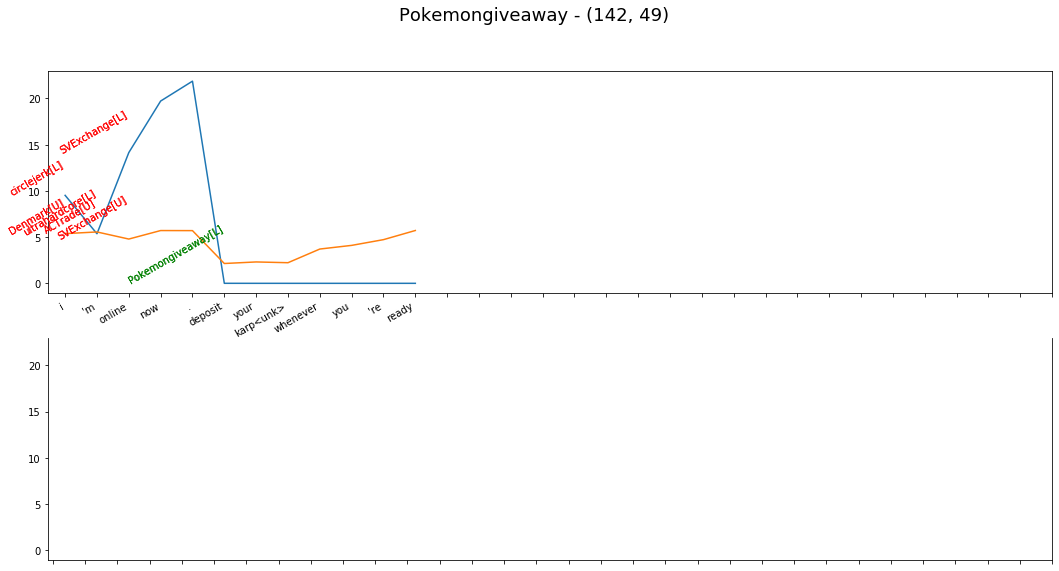

i 'm online now . deposit your karp<unk> whenever you 're ready




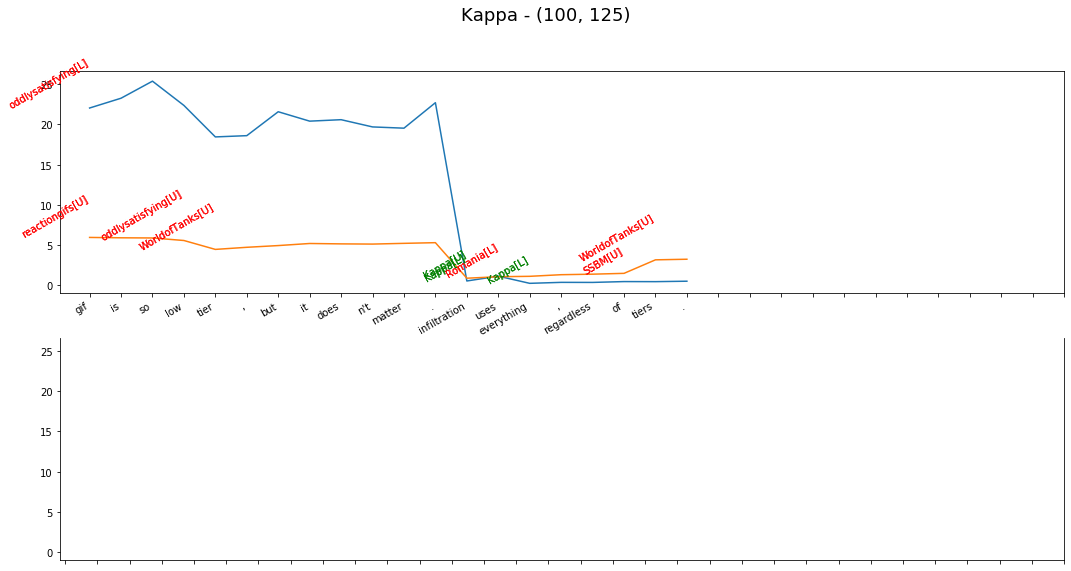

gif is so low tier , but it does n't matter . infiltration uses everything , regardless of tiers .




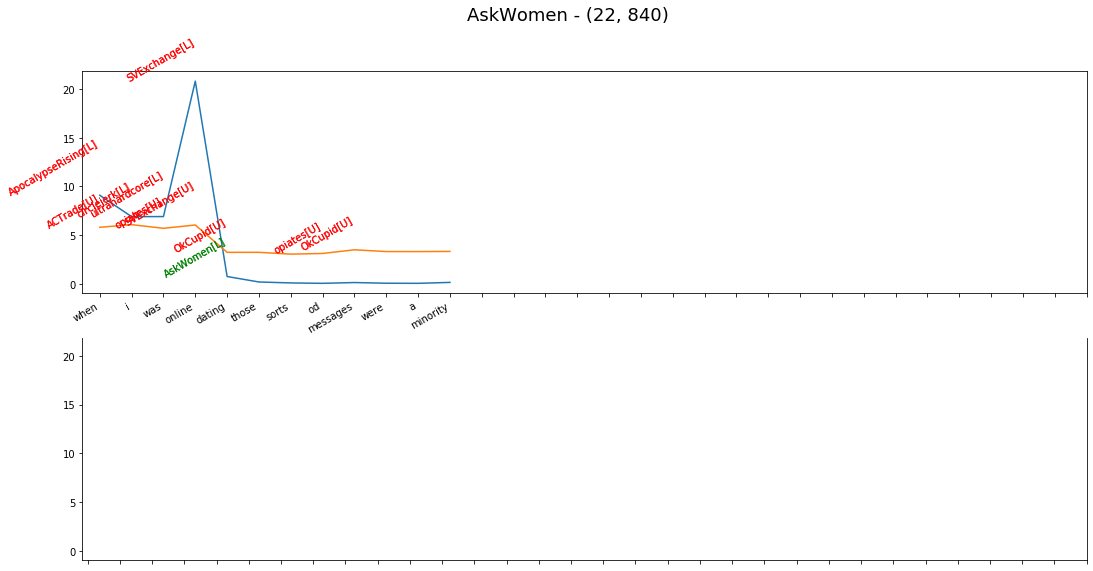

when i was online dating those sorts od messages were a minority




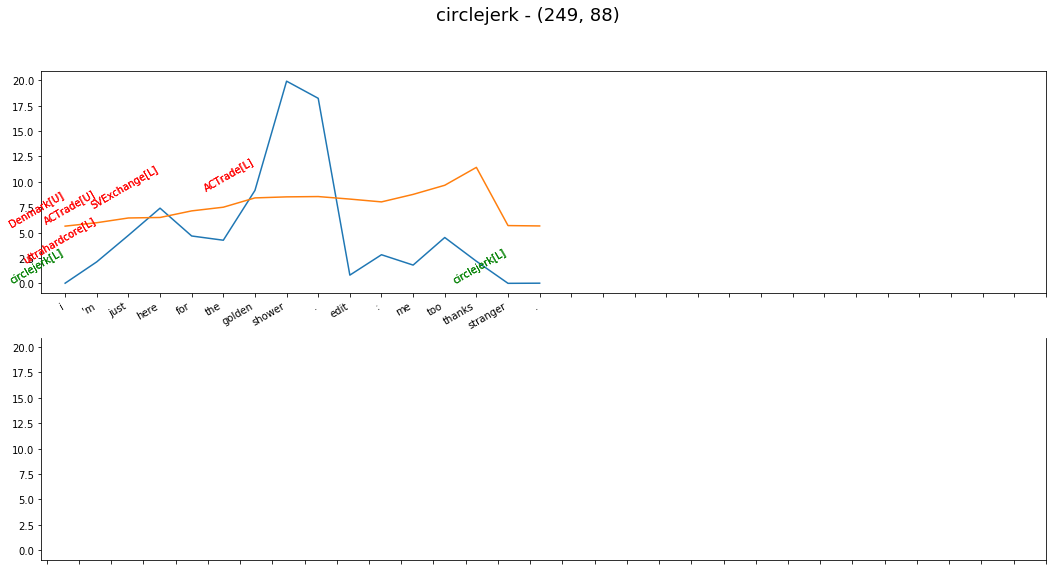

i 'm just here for the golden shower . edit : me too thanks stranger .




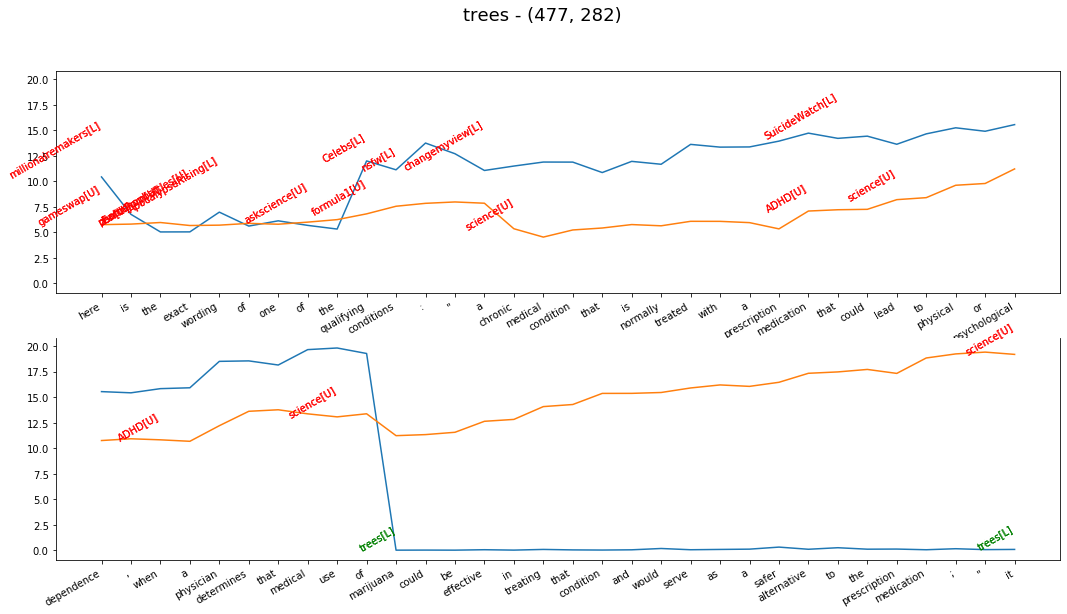

here is the exact wording of one of the qualifying conditions : " a chronic medical condition that is normally treated with a prescription medication that could lead to physical or psychological dependence , when a physician determines that medical use of marijuana could be effective in treating that condition and would serve as a safer alternative to the prescription medication ; " it




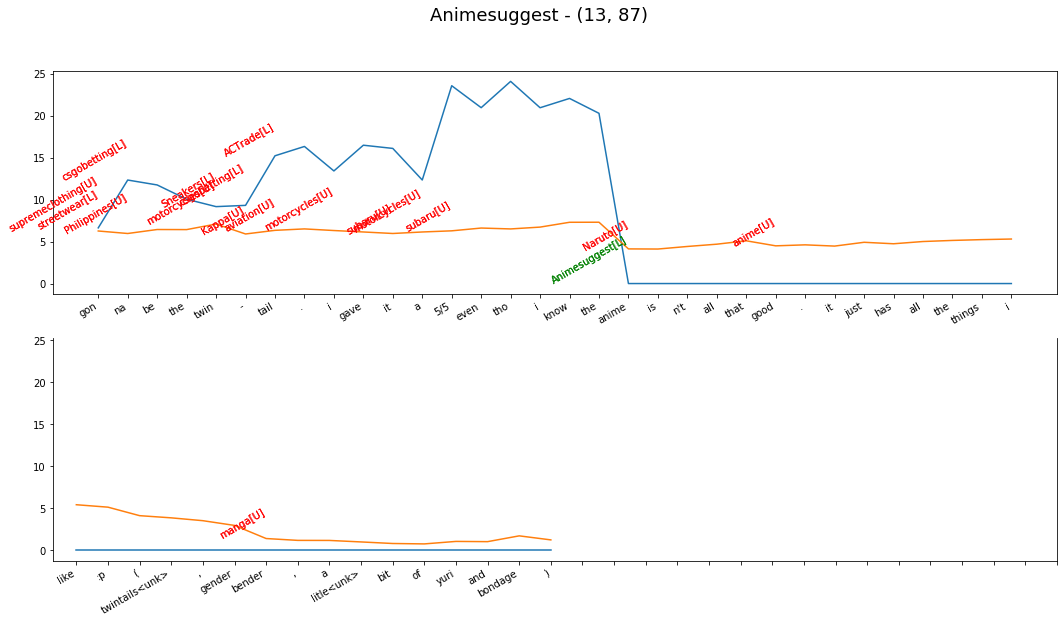

gon na be the twin - tail . i gave it a 5/5 even tho i know the anime is n't all that good . it just has all the things i like :p ( twintails<unk> , gender bender , a litle<unk> bit of yuri and bondage )




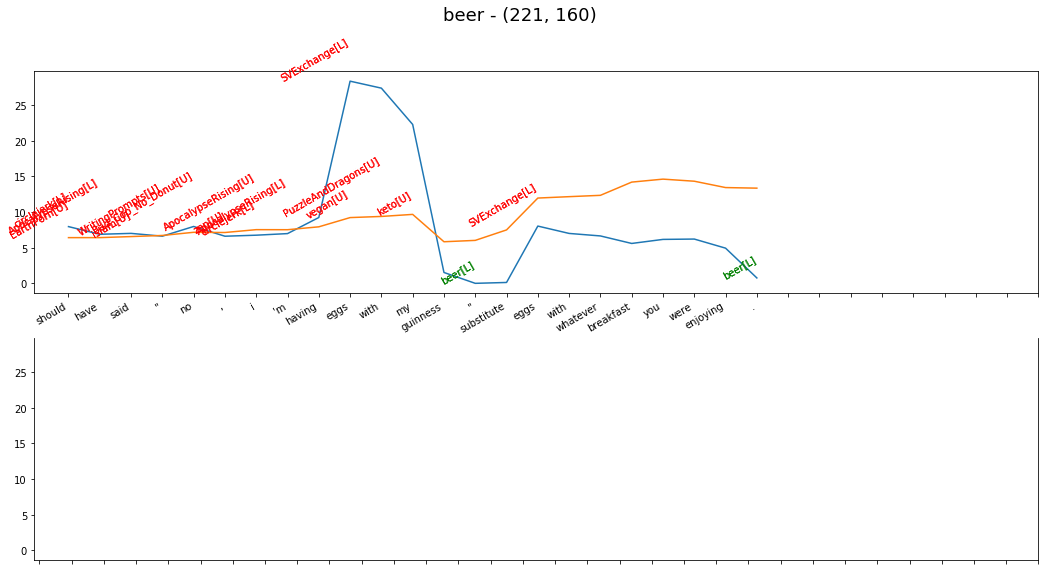

should have said " no , i 'm having eggs with my guinness " substitute eggs with whatever breakfast you were enjoying .




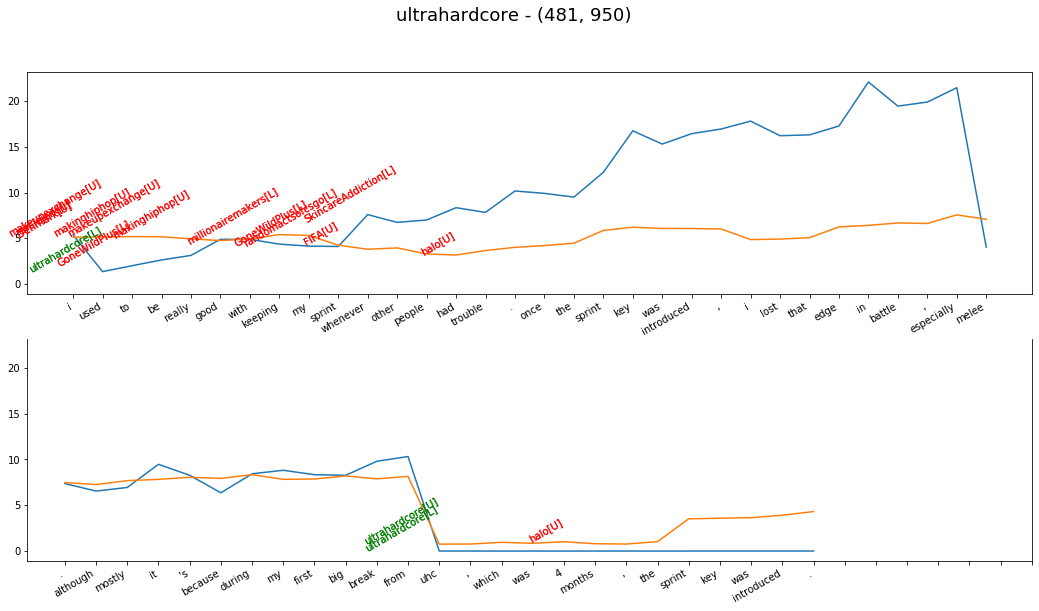

i used to be really good with keeping my sprint whenever other people had trouble . once the sprint key was introduced , i lost that edge in battle , especially melee . although mostly it 's because during my first big break from uhc , which was 4 months , the sprint key was introduced .




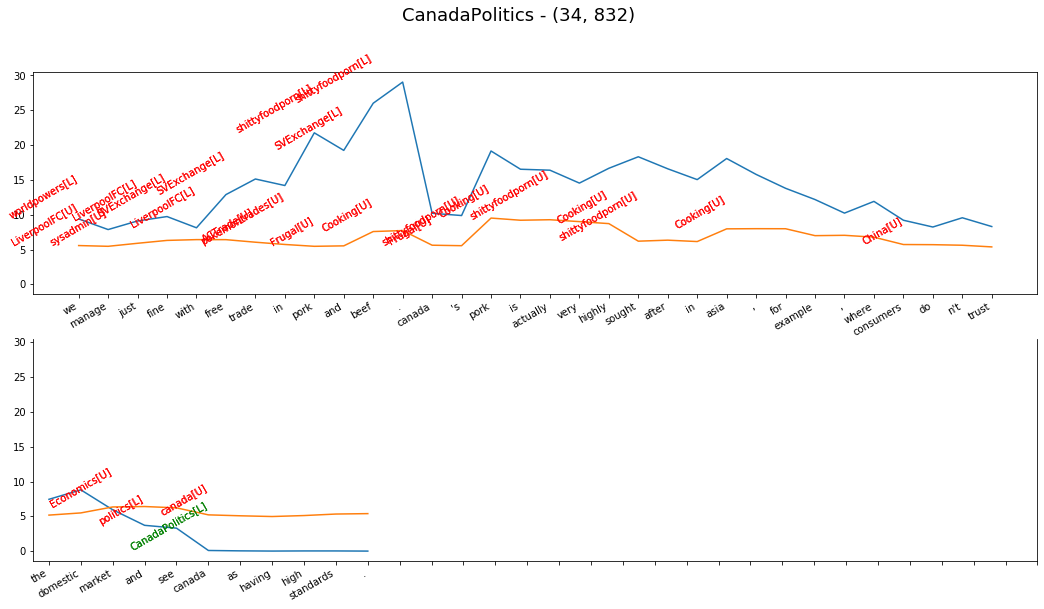

we manage just fine with free trade in pork and beef . canada 's pork is actually very highly sought after in asia , for example , where consumers do n't trust the domestic market and see canada as having high standards .




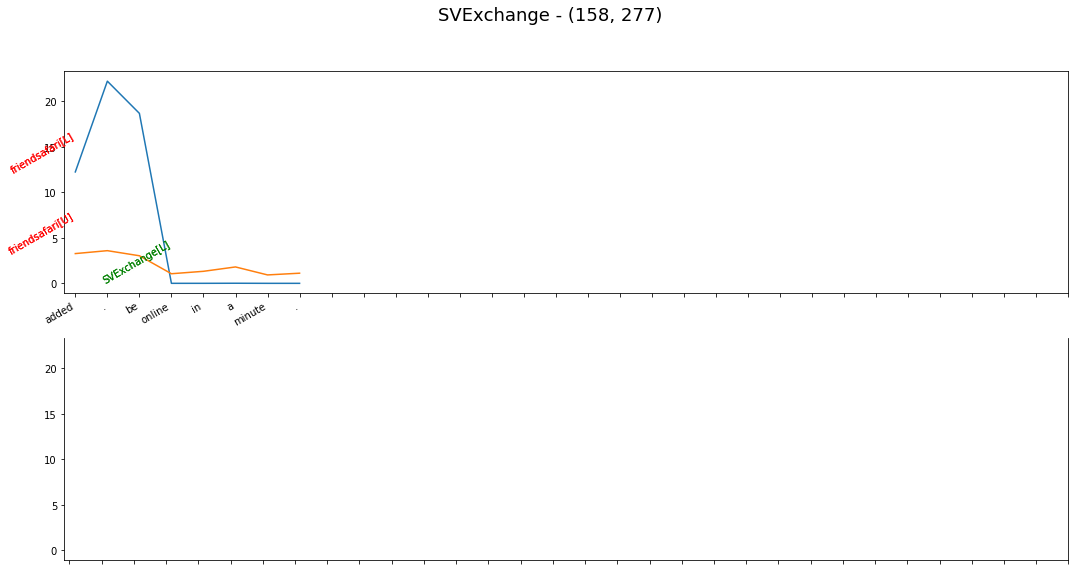

added . be online in a minute .




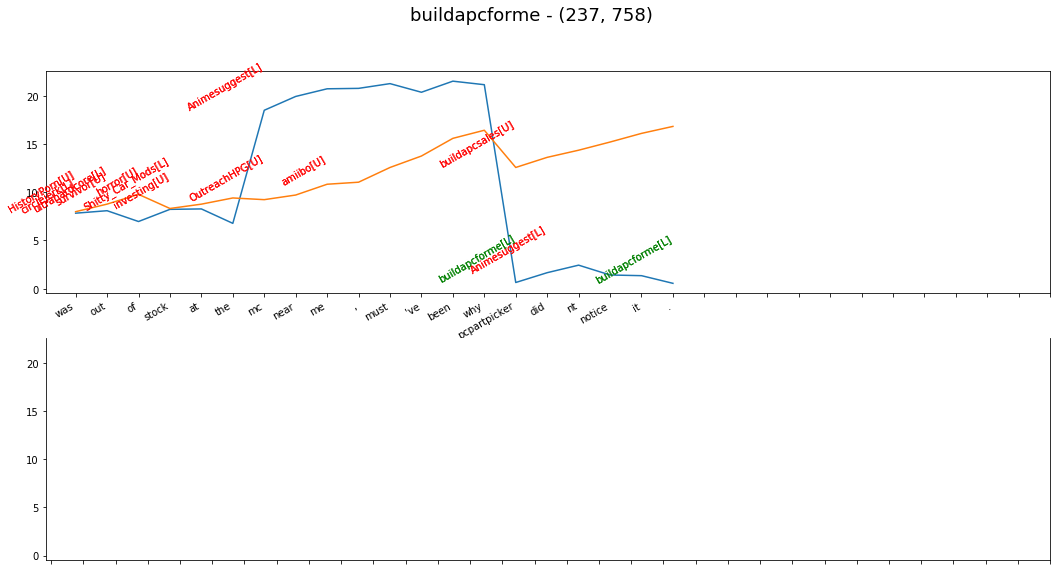

was out of stock at the mc near me , must 've been why pcpartpicker did nt notice it .




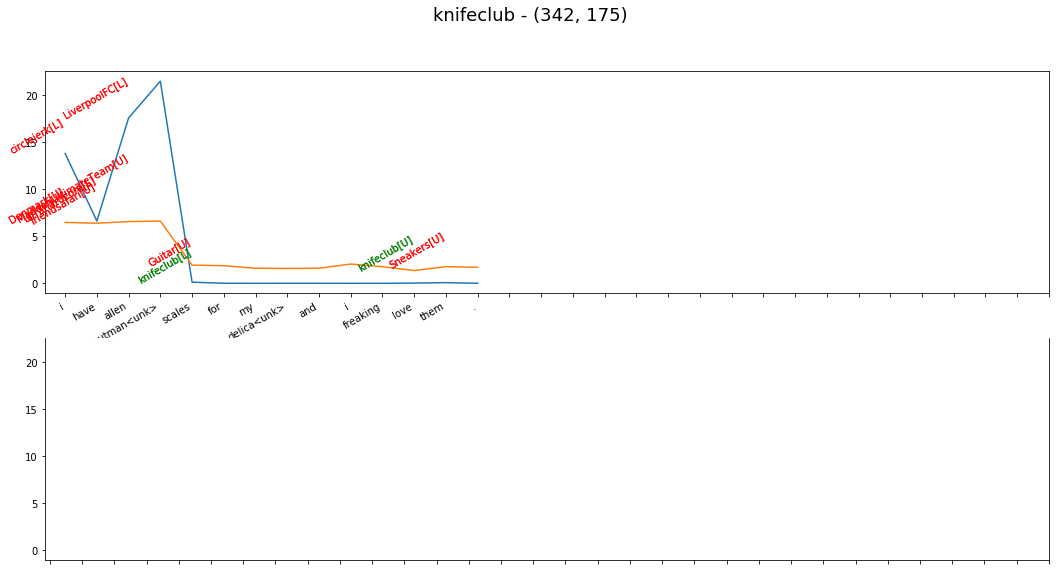

i have allen putman<unk> scales for my delica<unk> and i freaking love them .




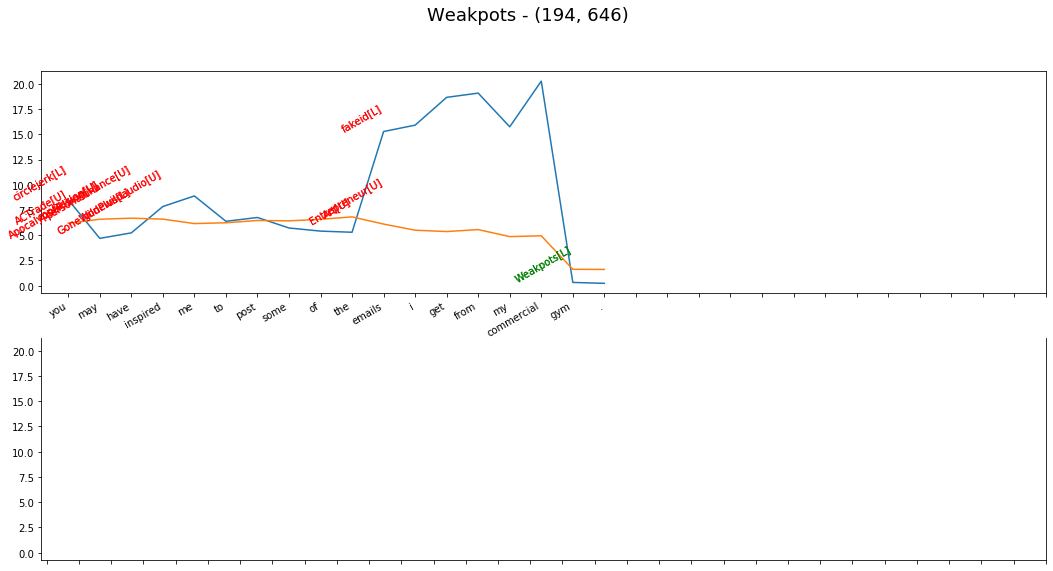

you may have inspired me to post some of the emails i get from my commercial gym .




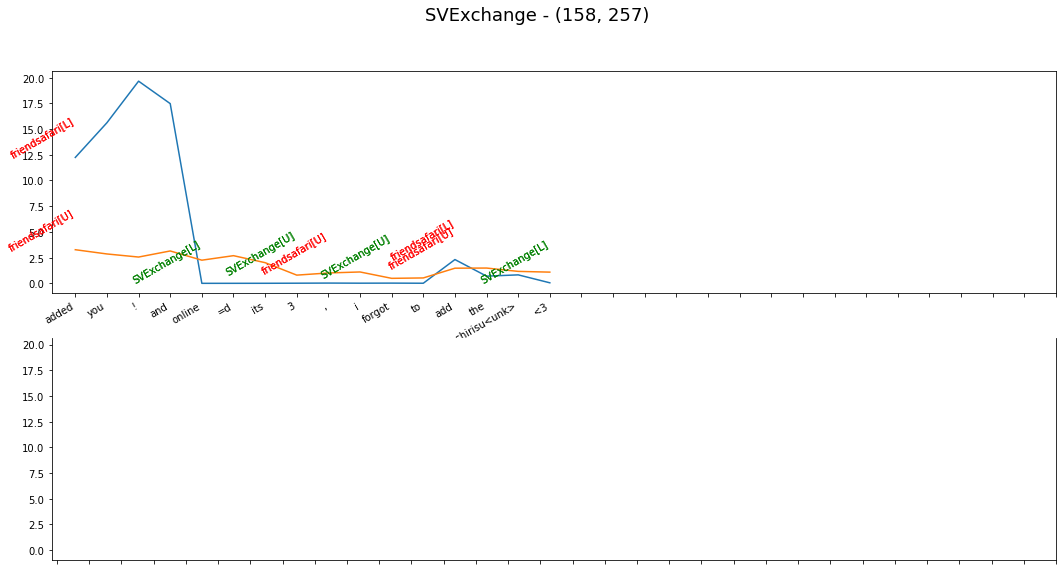

added you ! and online =d its 3 , i forgot to add the pachirisu<unk> <3




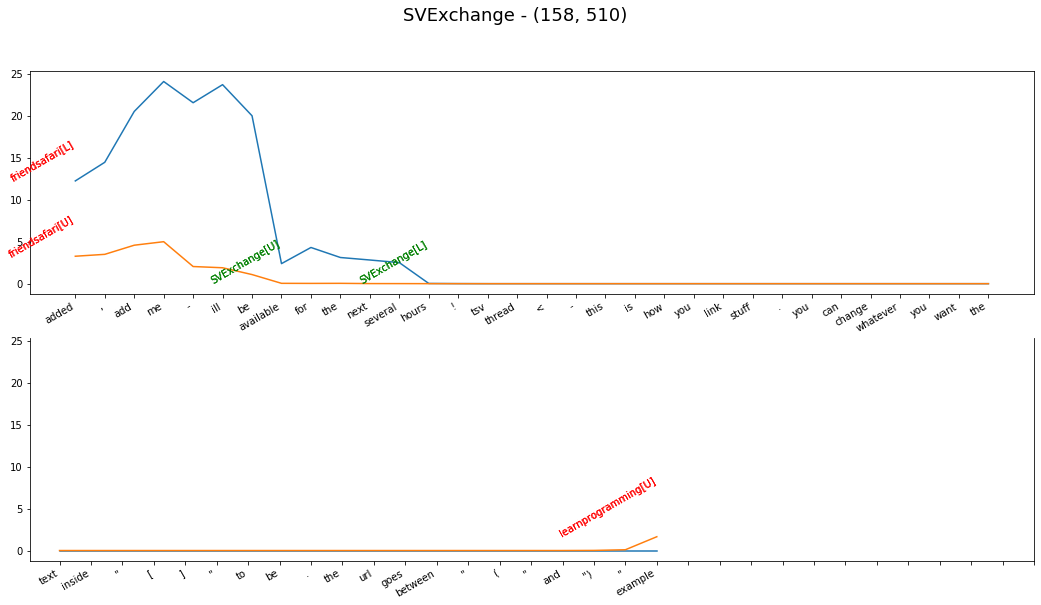

added , add me - ill be available for the next several hours ! tsv thread < - this is how you link stuff . you can change whatever you want the text inside " [ ] " to be . the url goes between " ( " and ") " example




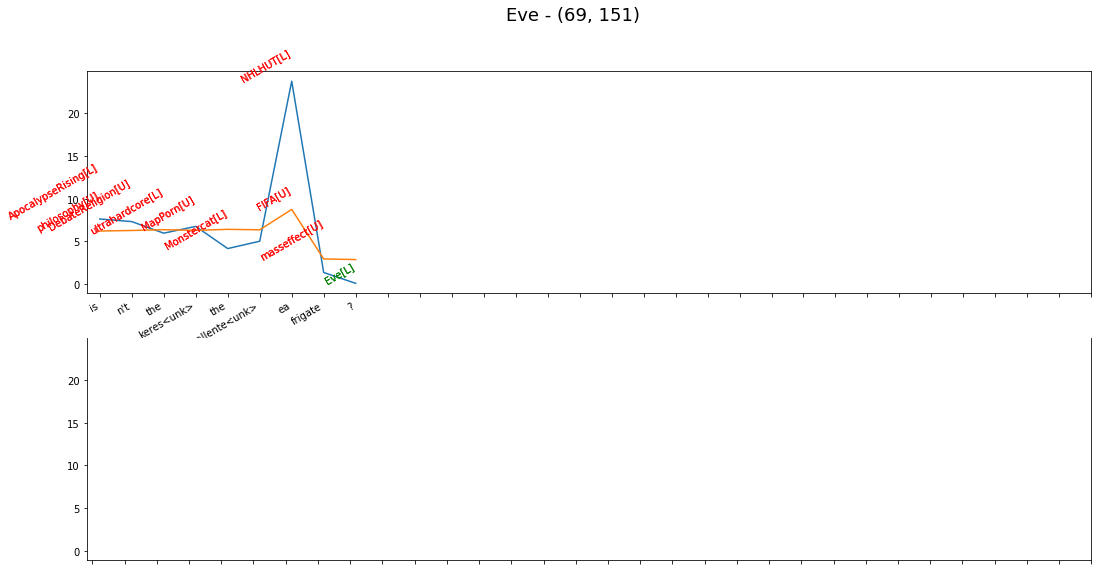

is n't the keres<unk> the gallente<unk> ea frigate ?




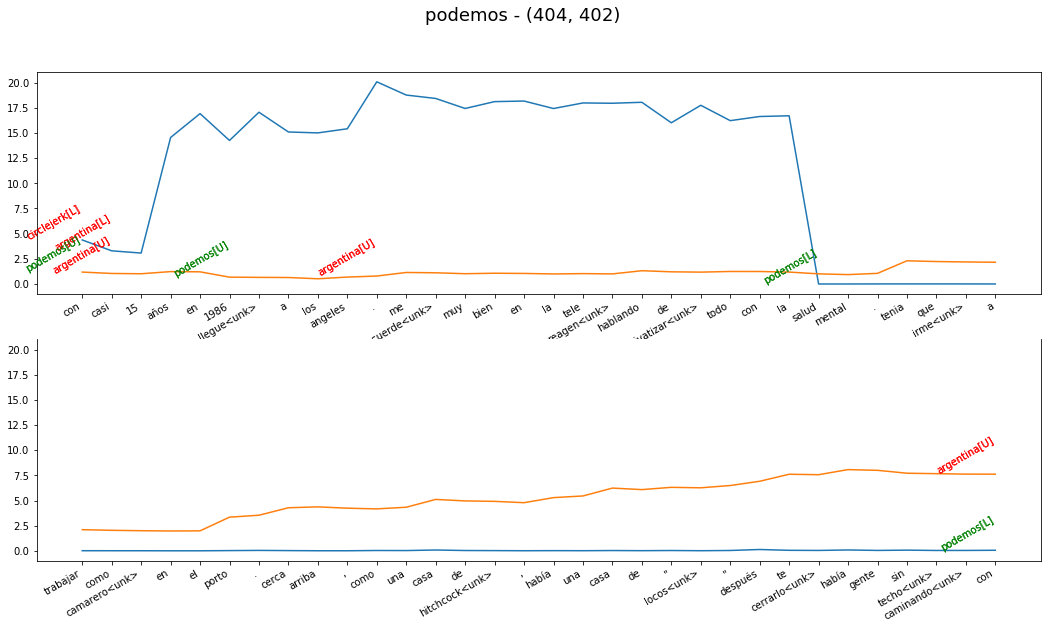

con casi 15 años en 1986 llegue<unk> a los angeles . me recuerde<unk> muy bien en la tele reagen<unk> hablando de privatizar<unk> todo con la salud mental . tenia que irme<unk> a trabajar como camarero<unk> en el porto . cerca arriba , como una casa de hitchcock<unk> , había una casa de " locos<unk> " después te cerrarlo<unk> había gente sin techo<unk> caminando<unk> con




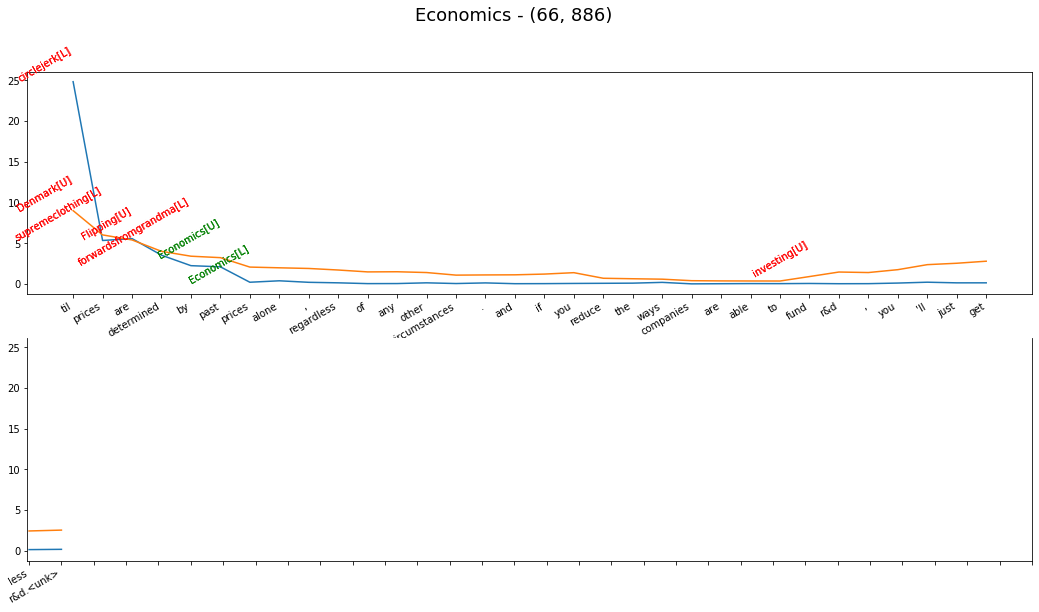

til prices are determined by past prices alone , regardless of any other circumstances . and if you reduce the ways companies are able to fund r&d , you 'll just get less r&d.<unk>




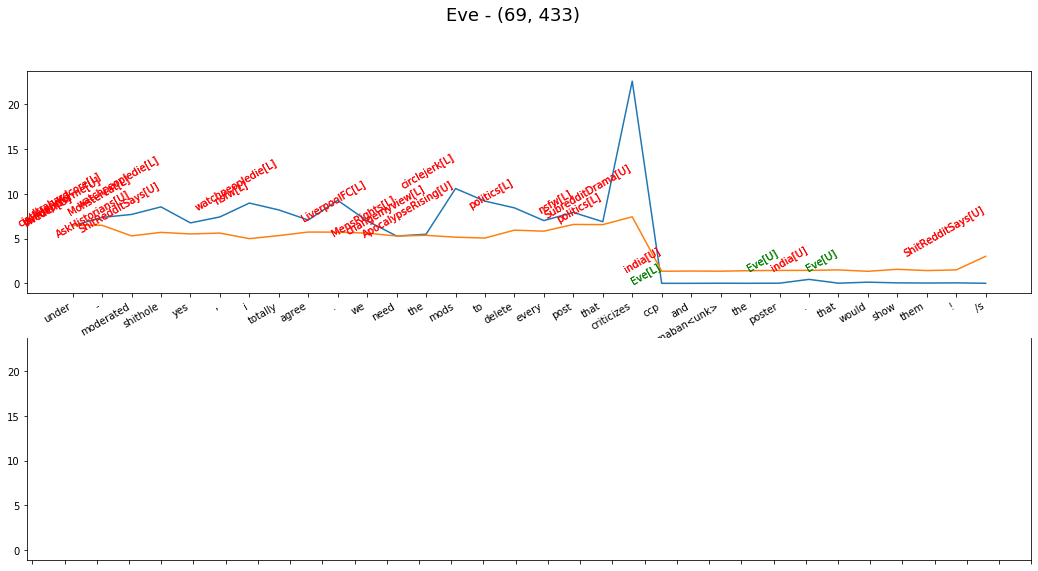

under - moderated shithole yes , i totally agree . we need the mods to delete every post that criticizes ccp and permaban<unk> the poster . that would show them ! /s




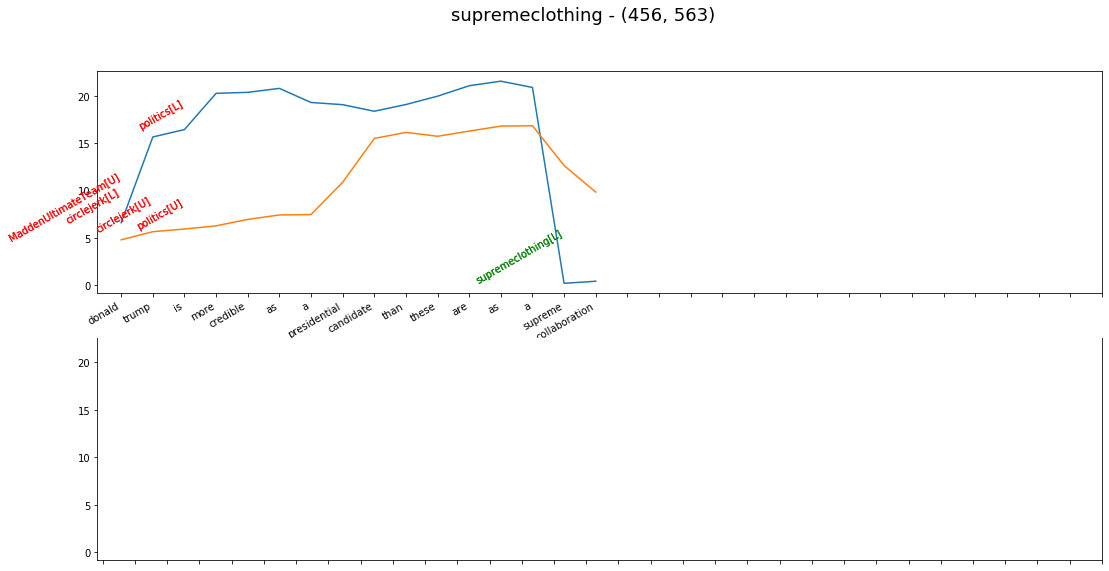

donald trump is more credible as a presidential candidate than these are as a supreme collaboration




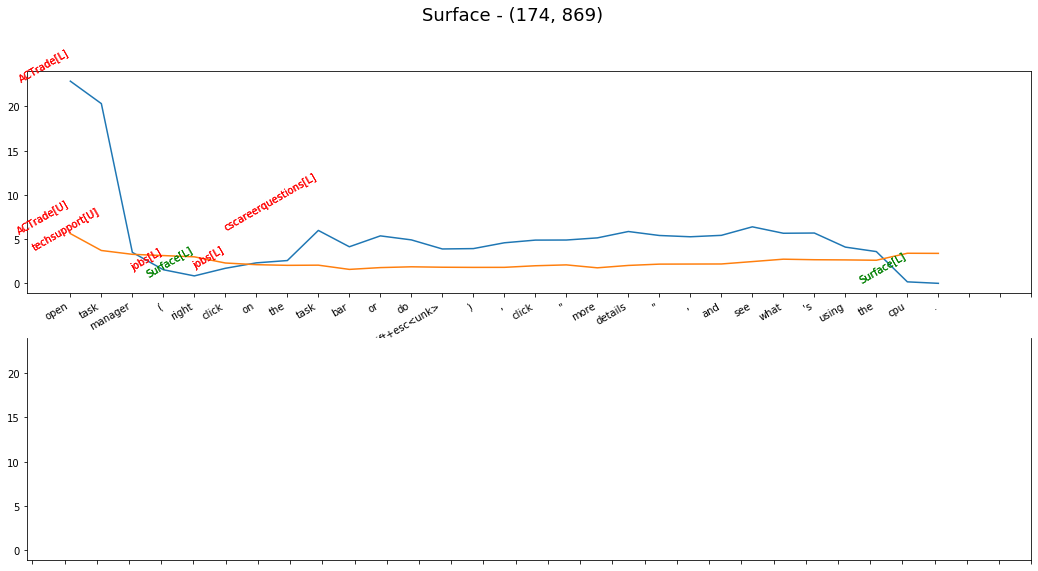

open task manager ( right click on the task bar or do ctrl+shift+esc<unk> ) , click " more details " , and see what 's using the cpu .




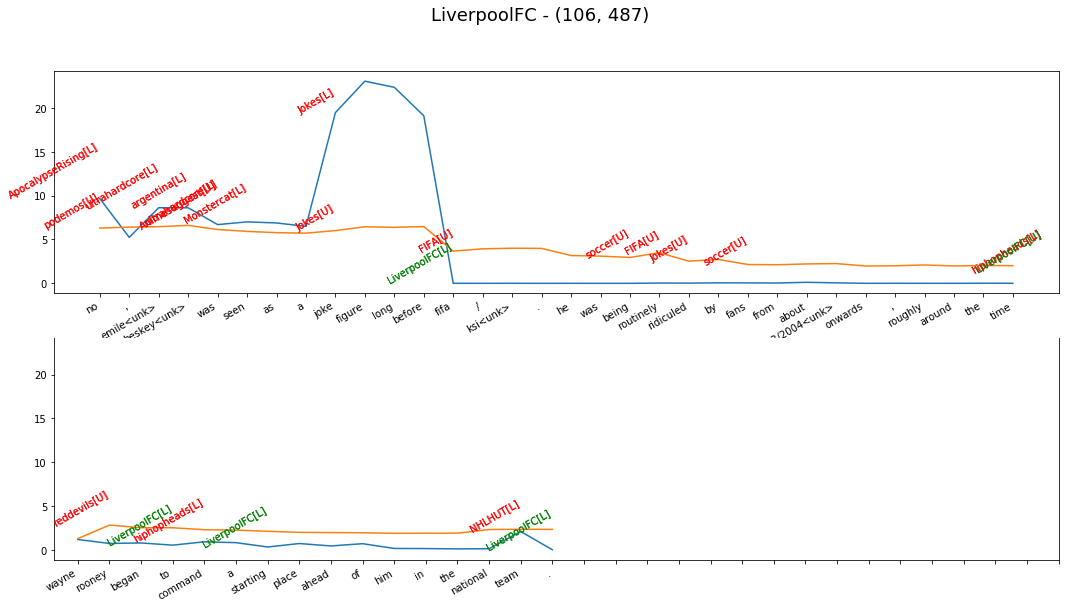

no , emile<unk> heskey<unk> was seen as a joke figure long before fifa / ksi<unk> . he was being routinely ridiculed by fans from about 2003/2004<unk> onwards , roughly around the time wayne rooney began to command a starting place ahead of him in the national team .




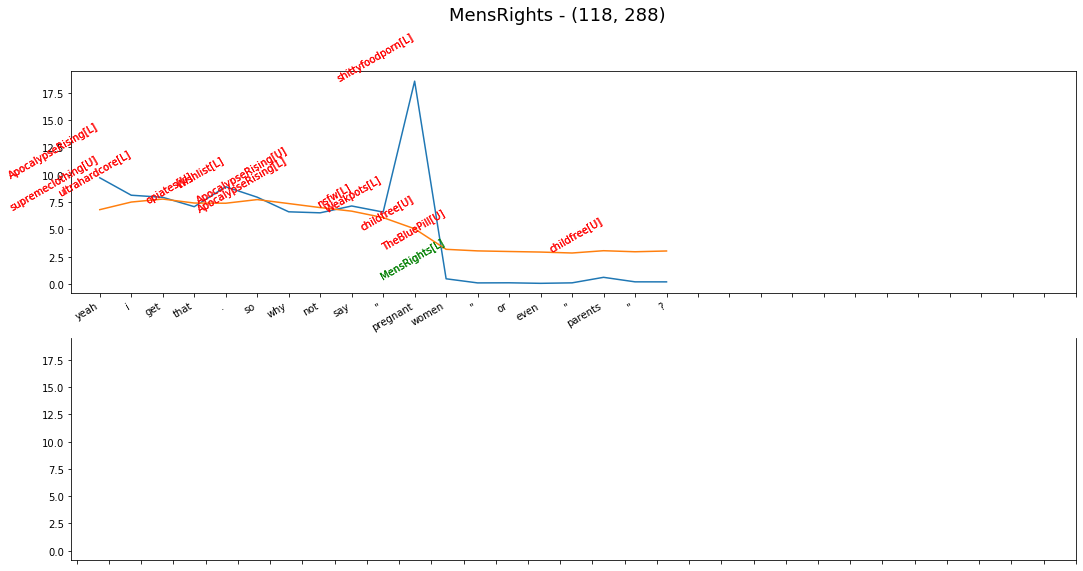

yeah i get that . so why not say " pregnant women " or even " parents " ?




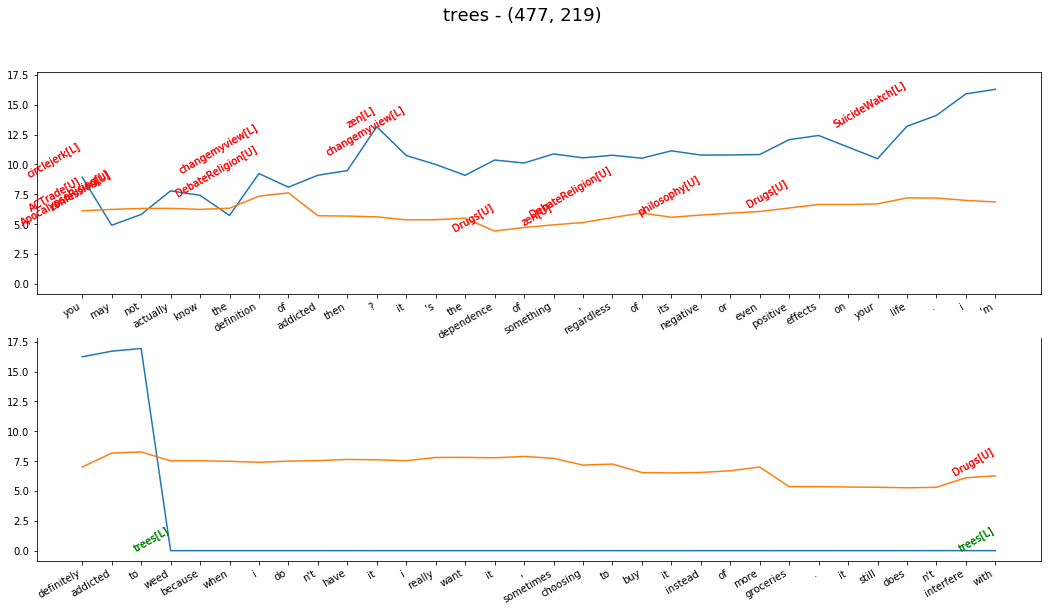

you may not actually know the definition of addicted then ? it 's the dependence of something , regardless of its negative or even positive effects on your life . i 'm definitely addicted to weed because when i do n't have it i really want it , sometimes choosing to buy it instead of more groceries . it still does n't interfere with




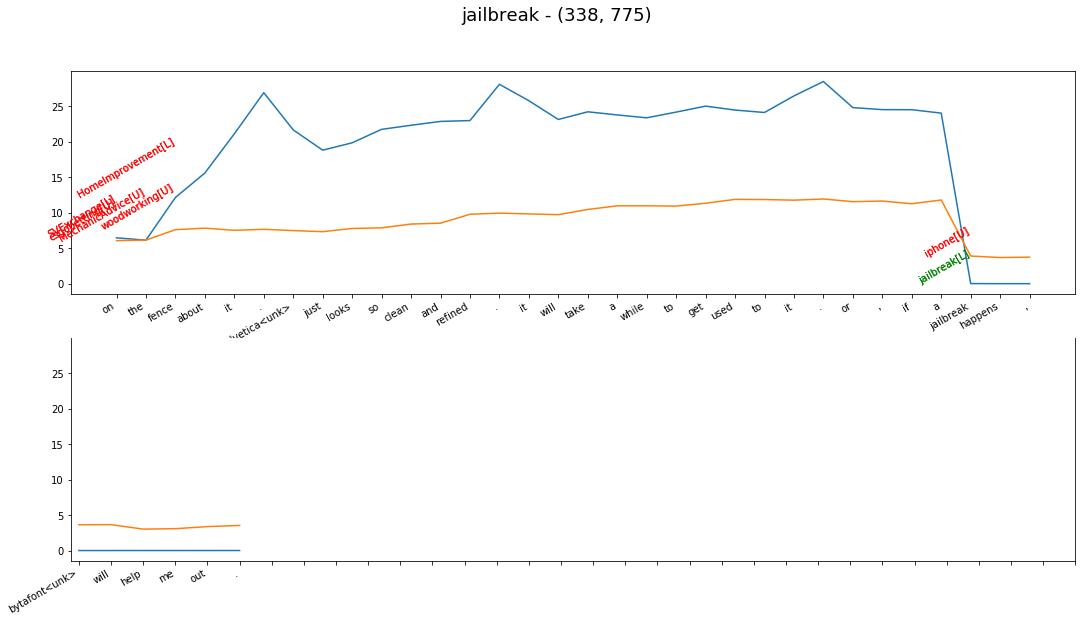

on the fence about it . helvetica<unk> just looks so clean and refined . it will take a while to get used to it . or , if a jailbreak happens , bytafont<unk> will help me out .




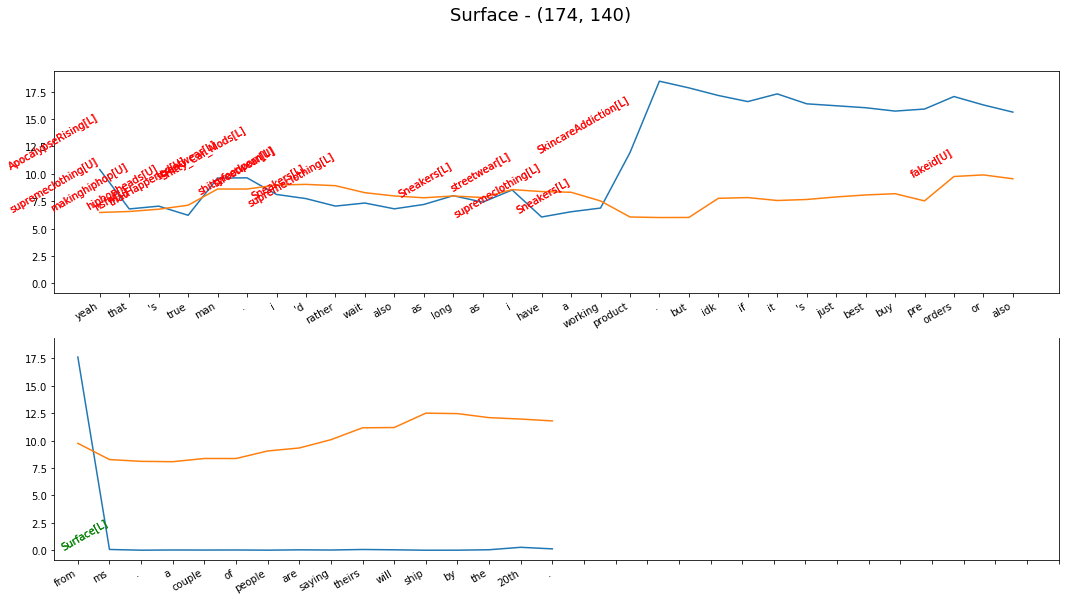

yeah that 's true man . i 'd rather wait also as long as i have a working product . but idk if it 's just best buy pre orders or also from ms . a couple of people are saying theirs will ship by the 20th .




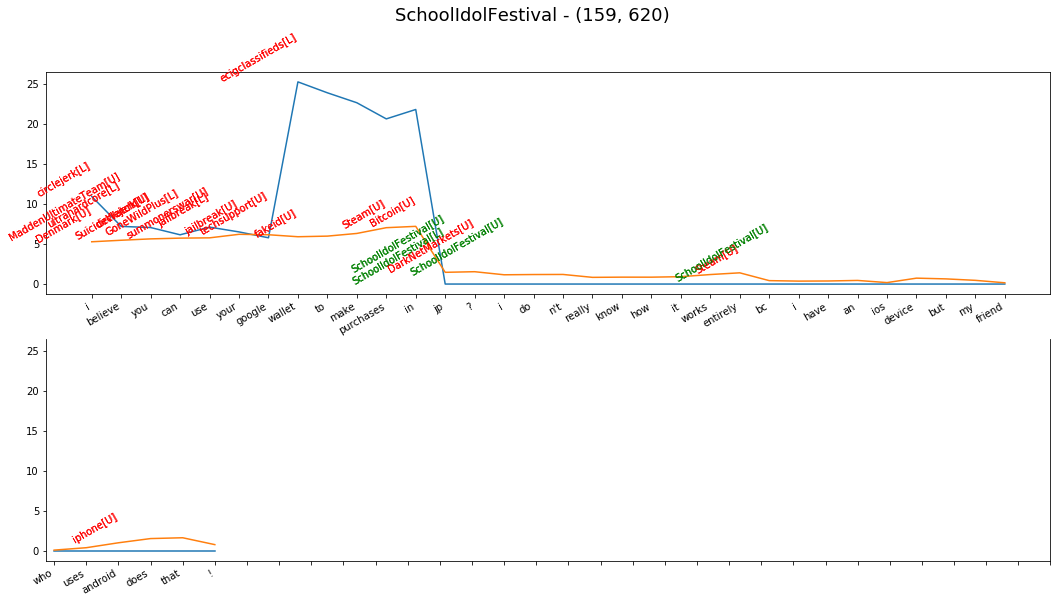

i believe you can use your google wallet to make purchases in jp ? i do n't really know how it works entirely bc i have an ios device but my friend who uses android does that !




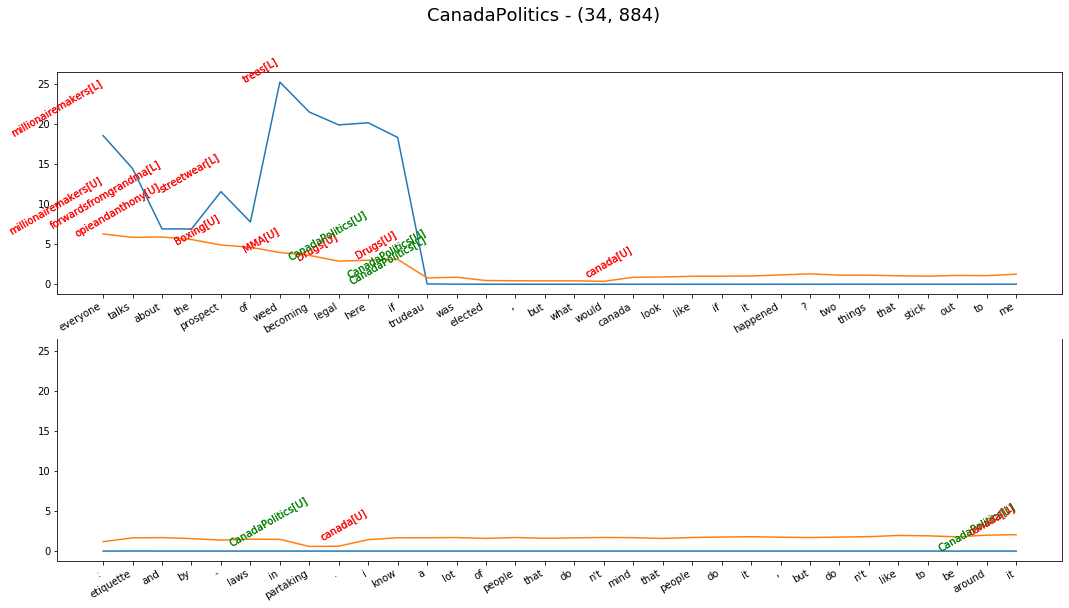

everyone talks about the prospect of weed becoming legal here if trudeau was elected , but what would canada look like if it happened ? two things that stick out to me : etiquette and by - laws in partaking . i know a lot of people that do n't mind that people do it , but do n't like to be around it




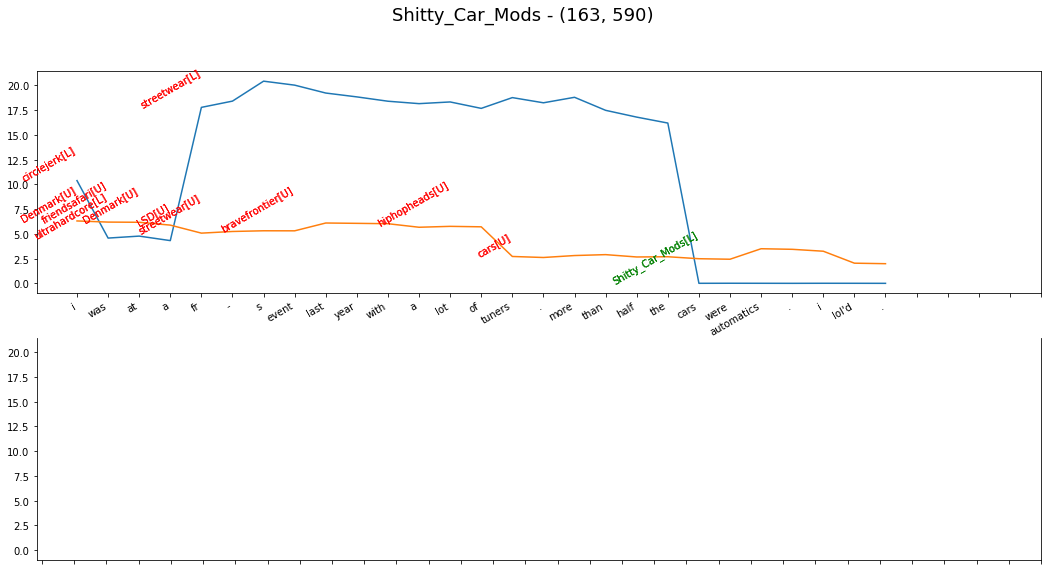

i was at a fr - s event last year with a lot of tuners . more than half the cars were automatics . i lol'd .




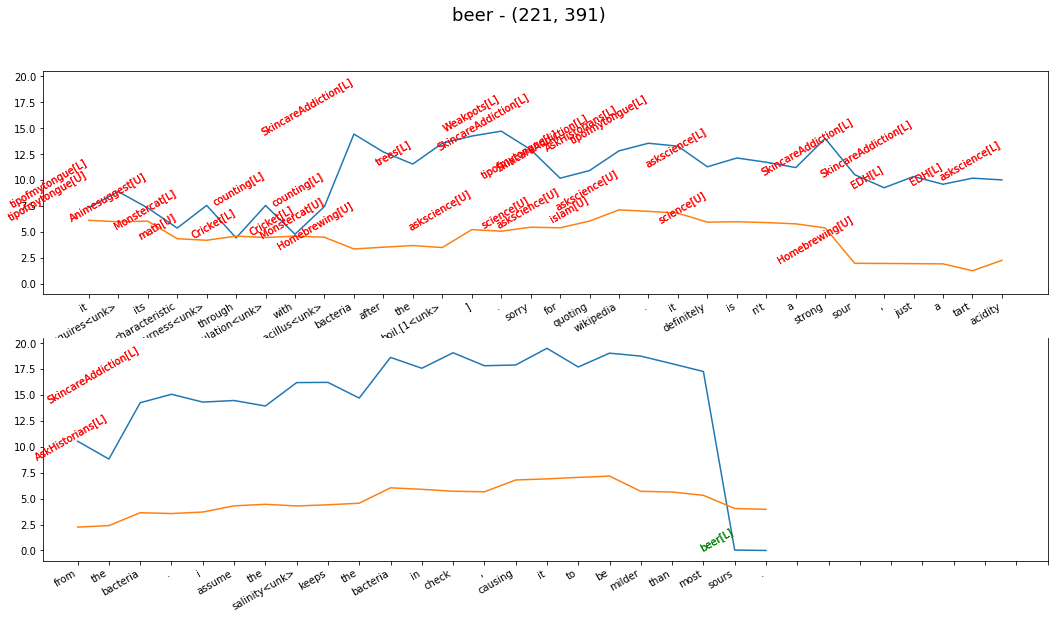

it acquires<unk> its characteristic sourness<unk> through inoculation<unk> with lactobacillus<unk> bacteria after the boil.[1<unk> ] . sorry for quoting wikipedia . it definitely is n't a strong sour , just a tart acidity from the bacteria . i assume the salinity<unk> keeps the bacteria in check , causing it to be milder than most sours .




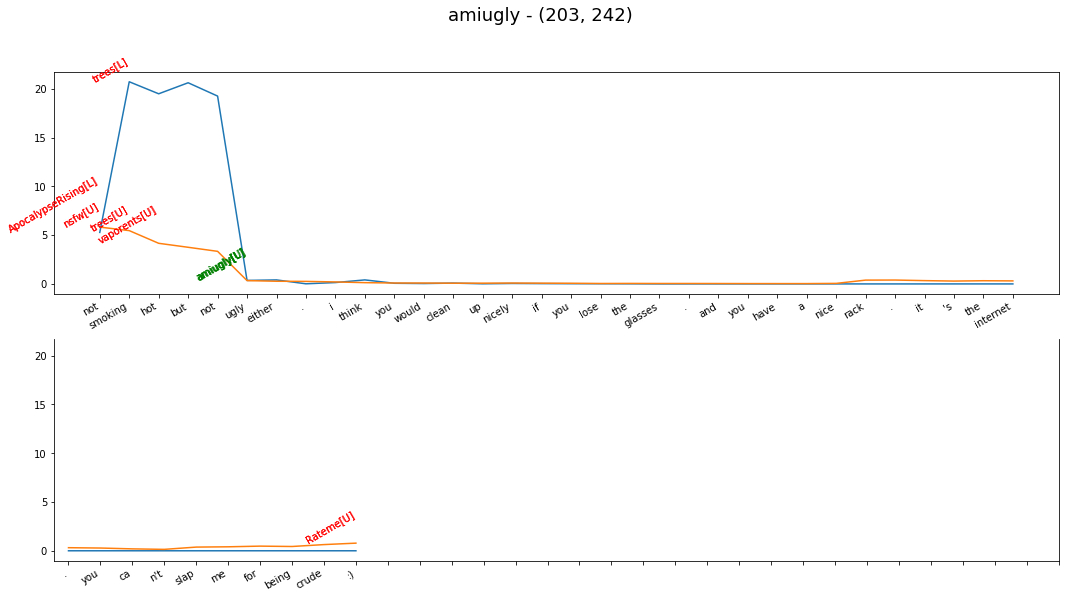

not smoking hot but not ugly either . i think you would clean up nicely if you lose the glasses . and you have a nice rack . it 's the internet . you ca n't slap me for being crude :)




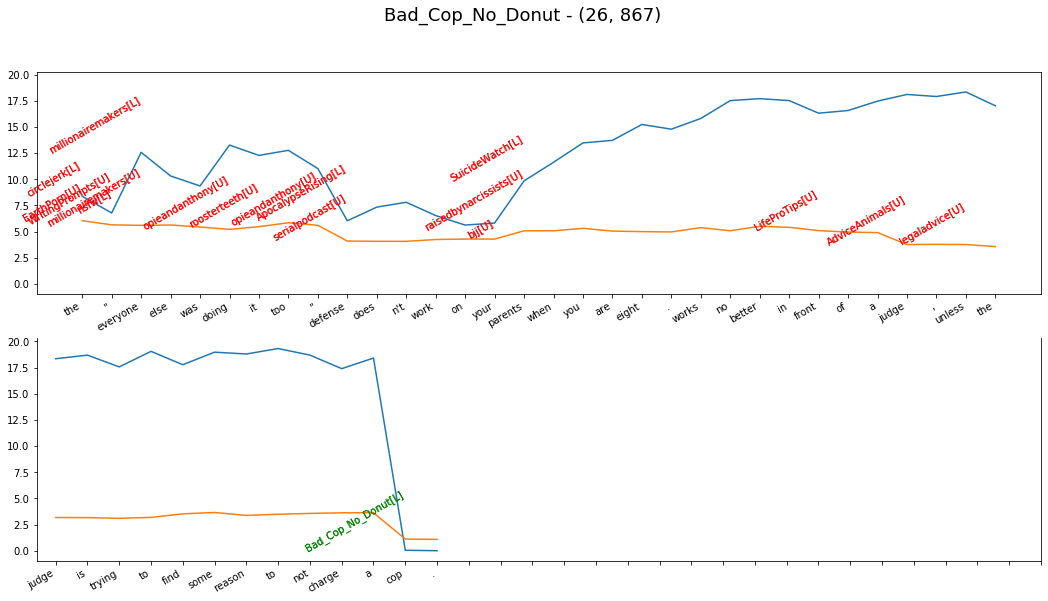

the " everyone else was doing it too " defense does n't work on your parents when you are eight . works no better in front of a judge , unless the judge is trying to find some reason to not charge a cop .




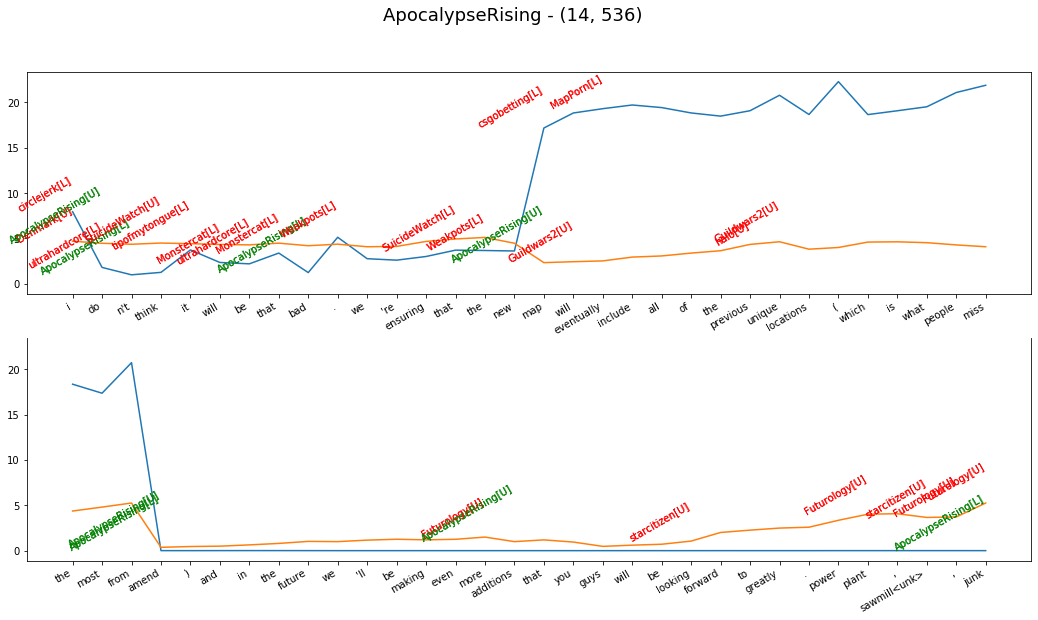

i do n't think it will be that bad . we 're ensuring that the new map will eventually include all of the previous unique locations ( which is what people miss the most from amend ) and in the future we 'll be making even more additions that you guys will be looking forward to greatly . power plant , sawmill<unk> , junk




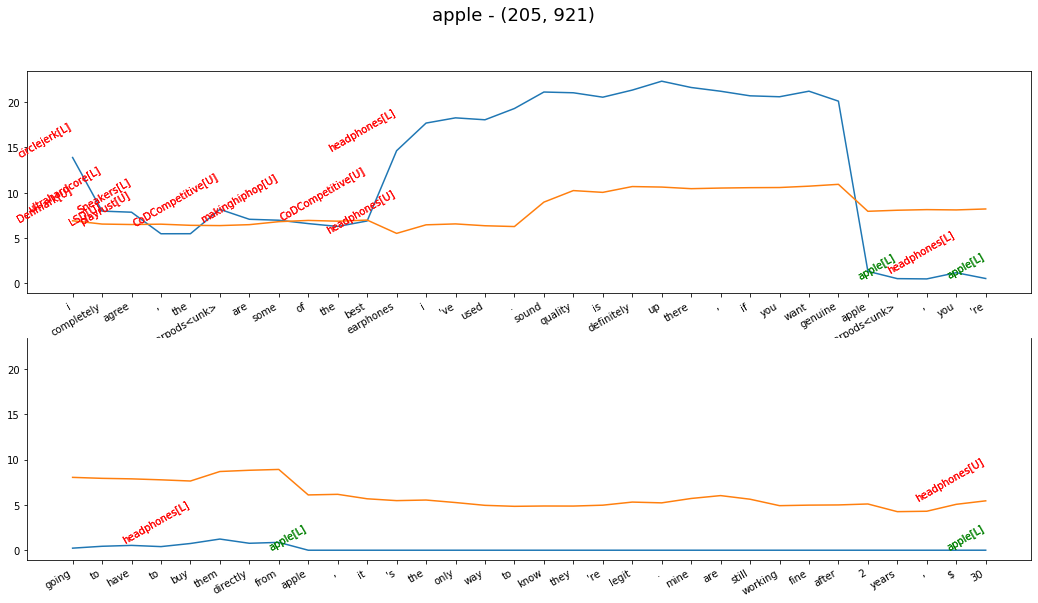

i completely agree , the earpods<unk> are some of the best earphones i 've used . sound quality is definitely up there , if you want genuine apple earpods<unk> , you 're going to have to buy them directly from apple , it 's the only way to know they 're legit . mine are still working fine after 2 years , $ 30




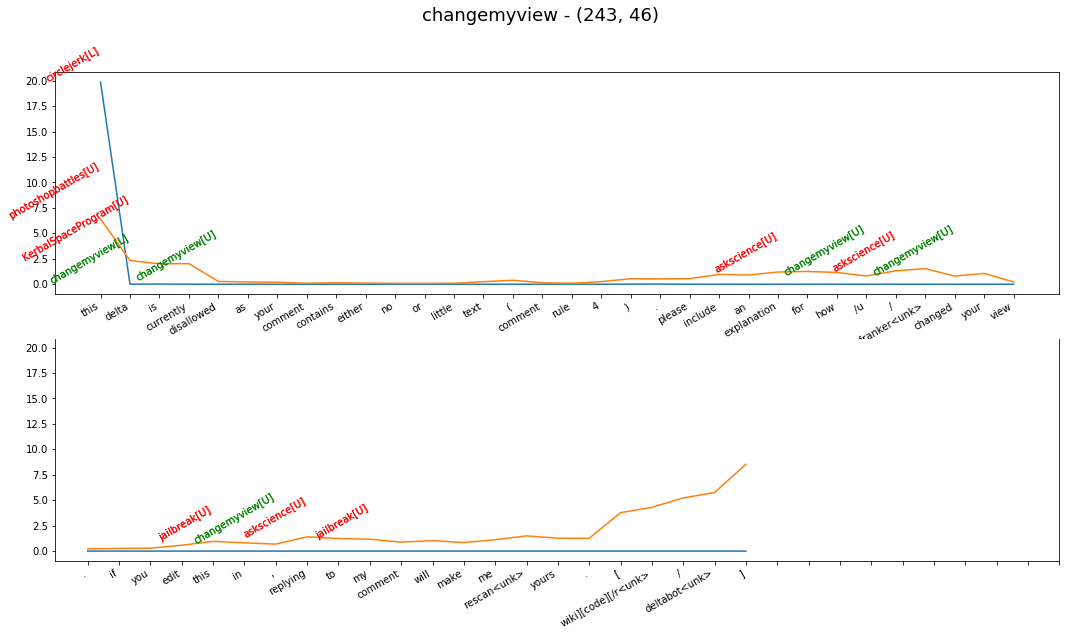

this delta is currently disallowed as your comment contains either no or little text ( comment rule 4 ) . please include an explanation for how /u / dafranker<unk> changed your view . if you edit this in , replying to my comment will make me rescan<unk> yours . [ wiki][code][/r<unk> / deltabot<unk> ]




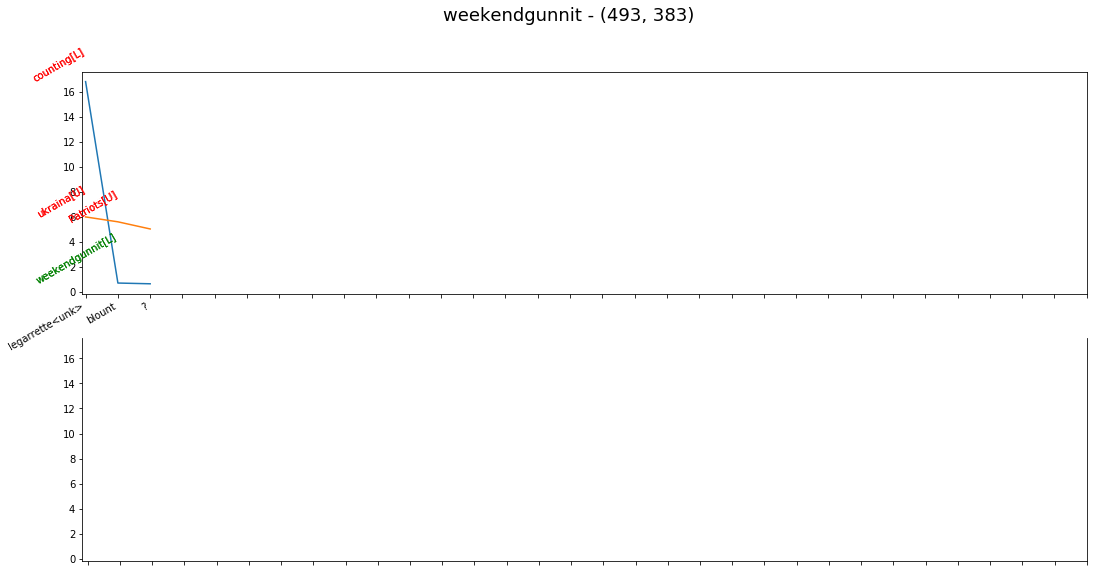

legarrette<unk> blount ?




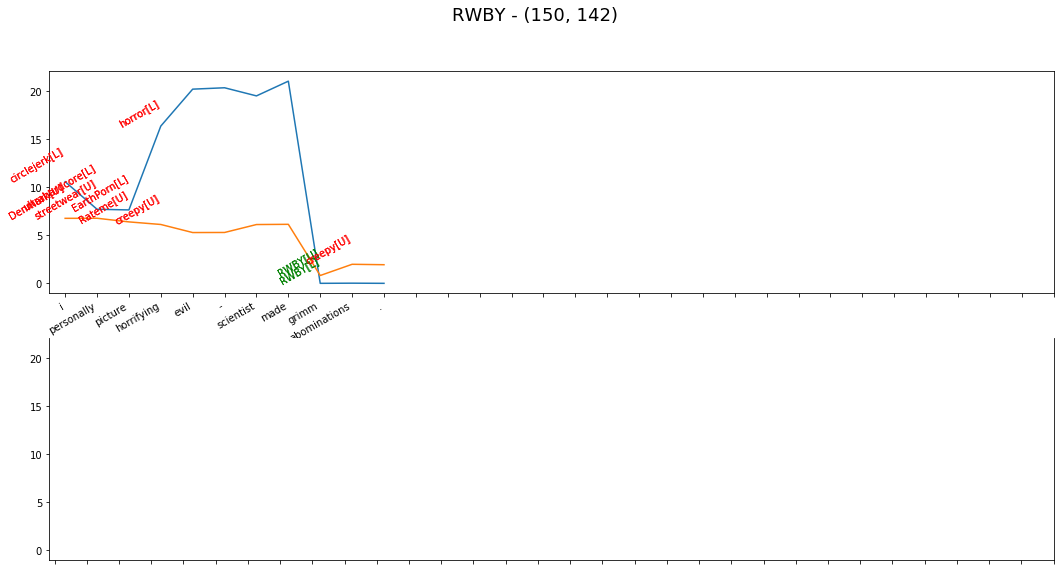

i personally picture horrifying evil - scientist made grimm abominations .




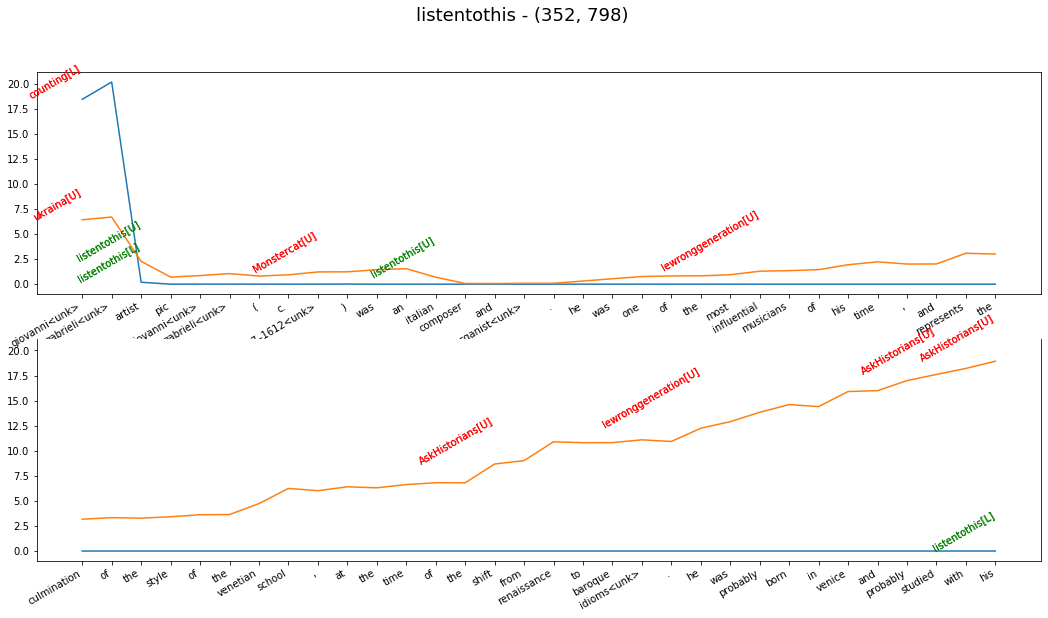

giovanni<unk> gabrieli<unk> artist pic giovanni<unk> gabrieli<unk> ( c. 1554/1557–1612<unk> ) was an italian composer and organist<unk> . he was one of the most influential musicians of his time , and represents the culmination of the style of the venetian school , at the time of the shift from renaissance to baroque idioms<unk> . he was probably born in venice and probably studied with his




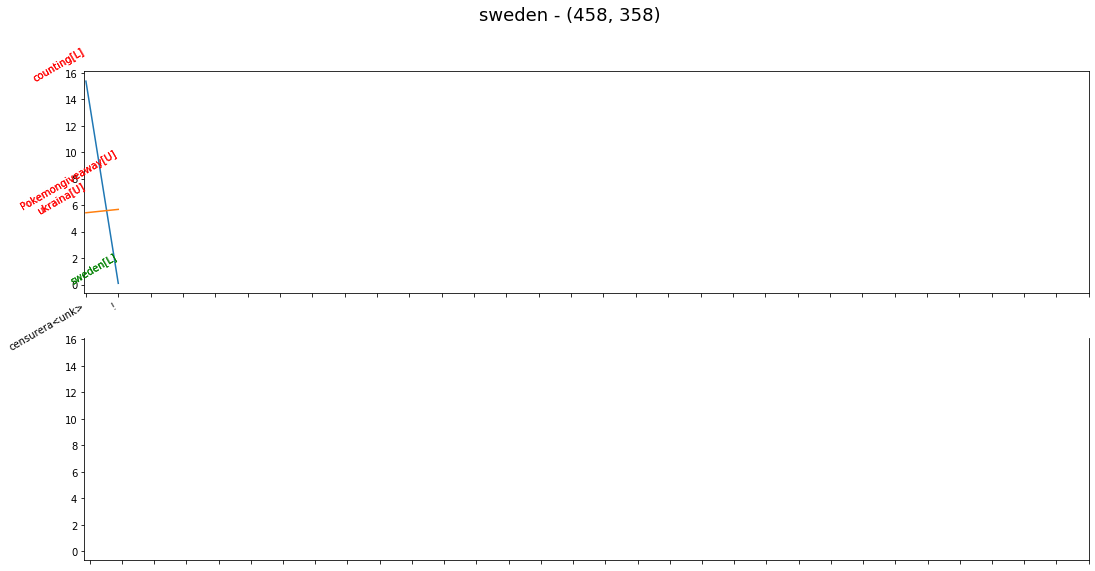

censurera<unk> !




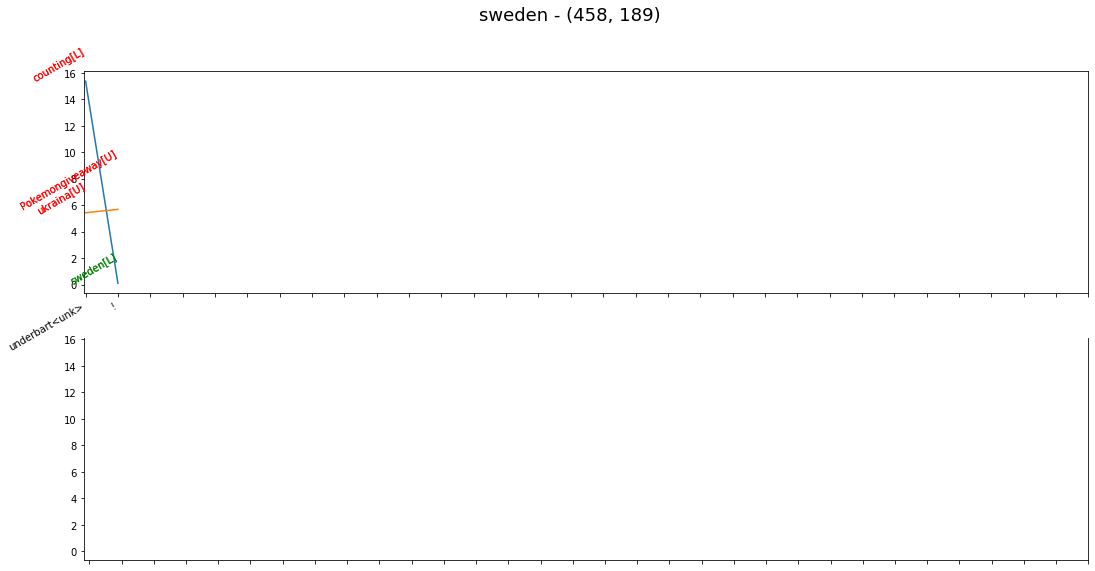

underbart<unk> !




In [13]:
for idx in lstm_wins.max(axis=1).replace(np.inf, np.nan).sort_values(ascending=False).head(50).index:
    plot_message(idx)